In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Getting the list of patients with age more tahn 18 years
patients_adm_age = pd.read_csv('/home/trips/Adult_patientsAge.csv')

# Getting list of all items along with the source and label
item_id_dbsource = pd.read_csv('./d_items_chartevents.csv')
# Getting list of all items along with the source and label
item_id_labs = pd.read_csv('./d_items_labevents.csv')

In [ ]:
patients_adm_age.head()

In [25]:
patients_adm_age.shape

(50765, 5)

In [ ]:
patients_adm_age[patients_adm_age['age']>=300]

In [27]:
# Whenever there is value >=300 in age column, replace it by 90
patients_adm_age.loc[patients_adm_age['age'] >= 300, 'age'] = 90

In [ ]:
# checking the unique age values
patients_adm_age['age'].unique()

In [29]:
list_itemid_num_MV = item_id_dbsource[(item_id_dbsource['dbsource']=='metavision') & (item_id_dbsource['param_type'].isin(['Numeric','Numeric with tag']))]['itemid']
list_itemid_cat_MV = item_id_dbsource[(item_id_dbsource['dbsource']=='metavision') & (item_id_dbsource['param_type'].isin(['Checkbox']))]['itemid']

In [30]:
print( "num of numerics in MV ", len(list_itemid_num_MV))
print( "num of cat in MV ", len(list_itemid_cat_MV))

num of numerics in MV  617
num of cat in MV  307


## Processing Labs

In [8]:
Mimic_lab_MV = pd.read_csv('mimic_labevents_metavision.csv')
Mimic_lab_CV = pd.read_csv('mimic_labevents_carevue.csv')

In [ ]:
Mimic_lab_CV.head()

In [10]:
Mimic_lab_MV_Formatted_value = Mimic_lab_MV.pivot(index='hadm_id', columns='itemid', values='valuenum')
Mimic_lab_CV_Formatted_value = Mimic_lab_CV.pivot(index='hadm_id', columns='itemid', values='valuenum')

In [11]:
Mimic_lab_CV_Formatted_value.columns

Int64Index([50800, 50801, 50802, 50803, 50804, 50805, 50806, 50808, 50809,
            50810,
            ...
            51511, 51512, 51513, 51514, 51515, 51516, 51517, 51518, 51519,
            51523],
           dtype='int64', name='itemid', length=581)

In [12]:
Mimic_lab_MV_Formatted_value.columns

Int64Index([50800, 50801, 50802, 50803, 50804, 50805, 50806, 50808, 50809,
            50810,
            ...
            51512, 51513, 51514, 51515, 51516, 51517, 51518, 51519, 51523,
            51529],
           dtype='int64', name='itemid', length=576)

In [13]:
# Selecting only labs that are common between two eras becasue the labs are going to be treated as known mapped features
Commonlab_lists =list(set(Mimic_lab_MV_Formatted_value.columns).intersection(set(Mimic_lab_CV_Formatted_value.columns)))
Mimic_lab_CV_Formatted_value= Mimic_lab_CV_Formatted_value[Commonlab_lists]

In [14]:
Mimic_lab_MV_Formatted_value=Mimic_lab_MV_Formatted_value[Commonlab_lists]

In [15]:
# Computing missing percentage and variance of each lab_item
percent_missing_CV_lab = Mimic_lab_CV_Formatted_value.isnull().sum() *100/ len(Mimic_lab_CV_Formatted_value)
Variance_CV_lab = Mimic_lab_CV_Formatted_value.var().round(2)
missing_value_df_CV_lab = pd.DataFrame({'column_name': Mimic_lab_CV_Formatted_value.columns,
                                 'percent_missing_CV': percent_missing_CV_lab, 'variance_CV' : Variance_CV_lab})
missing_value_df_CV_lab.reset_index(inplace=True)
missing_value_df_CV_lab = pd.merge(item_id_labs, missing_value_df_CV_lab, how="inner", on=["itemid"])
missing_value_df_CV_lab.sort_values(by='itemid', inplace=True)
missing_value_df_CV_lab.set_index('itemid', inplace=True)
missing_value_df_CV_lab.drop(columns=['row_id', 'column_name', 'fluid', 'category','loinc_code'], inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_df_CV_lab.round(3))
    
# filtering out the columns by missingness percent 
# missing_value_df_CV_lab[missing_value_df_CV_lab['percent_missing_CV']<40]

label  percent_missing_CV   variance_CV
itemid                                                                        
50800                          SPECIMEN TYPE             100.000           NaN
50801             Alveolar-arterial Gradient              89.759  1.527591e+04
50802                            Base Excess              45.907  1.810000e+01
50803    Calculated Bicarbonate, Whole Blood              98.324  2.814000e+01
50804                   Calculated Total CO2              45.898  2.552000e+01
50805                      Carboxyhemoglobin              99.509  8.200000e-01
50806                  Chloride, Whole Blood              89.927  3.323000e+01
50808                           Free Calcium              63.652  1.000000e-02
50809                                Glucose              72.332  3.666640e+03
50810                 Hematocrit, Calculated              78.007  3.100000e+01
50811                             Hemoglobin              78.007  3.430000e+00
50812                              Intubated             100.000           NaN
50813                                Lactate              69.377  3.180000e+00
50814                          Methemoglobin              99.555  4.300000e-01
50815                                O2 Flow              95.295  9.428800e+02
50816                                 Oxygen              73.063  6.798700e+02
50817                      Oxygen Saturation              70.702  1.934500e+02
50818                                   pCO2              45.904  8.773000e+01
50819                                   PEEP              82.482  5.734000e+01
50820                                     pH              43.942  0.000000e+00
50821                                    pO2              45.904  3.897840e+03
50822                 Potassium, Whole Blood              72.148  4.200000e-01
50823                            Required O2              89.750  2.872300e+02
50824                    Sodium, Whole Blood              80.878  2.262000e+01
50825                            Temperature              76.875  9.200000e-01
50826                           Tidal Volume              81.590  3.119851e+04
50827                       Ventilation Rate             100.000           NaN
50828                             Ventilator             100.000           NaN
50831                                     pH              99.782  7.000000e-02
50835                       Albumin, Ascites              99.863  6.100000e-01
50836                       Amylase, Ascites              99.857  3.665571e+07
50838              Bilirubin, Total, Ascites              99.904  4.751200e+02
50841                    Creatinine, Ascites              99.944  1.400000e+00
50842                       Glucose, Ascites              99.729  6.513960e+03
50843         Lactate Dehydrogenase, Ascites              99.708  2.817315e+05
50849                 Total Protein, Ascites              99.621  1.990000e+00
50850                 Triglycerides, Ascites              99.988  2.394825e+04
50852                       % Hemoglobin A1c              96.896  4.160000e+00
50856                          Acetaminophen              99.761  3.033820e+03
50857                                Acetone             100.000           NaN
50861         Alanine Aminotransferase (ALT)              73.949  4.485354e+05
50862                                Albumin              78.349  4.200000e-01
50863                   Alkaline Phosphatase              74.848  2.385611e+04
50864                      Alpha-Fetoprotein              99.723  1.383819e+10
50866                                Ammonia              99.238  4.936650e+03
50867                                Amylase              86.326  4.004552e+04
50868                              Anion Gap              16.056  1.232000e+01
50871            Anti-Mitochondrial Antibody             100.000           NaN
50872   Anti-Neutrophil Cytoplasmic Antibody             100.000           NaN
50873     

In [16]:
# Computing missing percentage and variance of each lab_item
percent_missing_MV_lab = Mimic_lab_MV_Formatted_value.isnull().sum() *100/ len(Mimic_lab_MV_Formatted_value)
Variance_MV_lab = Mimic_lab_MV_Formatted_value.var().round(2)
missing_value_df_MV_lab = pd.DataFrame({'column_name': Mimic_lab_MV_Formatted_value.columns,
                                 'percent_missing_MV': percent_missing_MV_lab, 'variance_MV' : Variance_MV_lab})
missing_value_df_MV_lab.reset_index(inplace=True)
missing_value_df_MV_lab = pd.merge(item_id_labs, missing_value_df_MV_lab, how="inner", on=["itemid"])
missing_value_df_MV_lab.sort_values(by='itemid', inplace=True)
missing_value_df_MV_lab.set_index('itemid', inplace=True)
missing_value_df_MV_lab.drop(columns=['row_id', 'column_name', 'fluid', 'category','loinc_code'], inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_df_MV_lab.round(3))
    
# filtering out the columns by missingness percent 
# missing_value_df_CV_lab[missing_value_df_CV_lab['percent_missing_CV']<40]

label  percent_missing_MV   variance_MV
itemid                                                                        
50800                          SPECIMEN TYPE             100.000           NaN
50801             Alveolar-arterial Gradient              95.126  1.644799e+04
50802                            Base Excess              50.716  3.704000e+01
50803    Calculated Bicarbonate, Whole Blood              98.493  3.445000e+01
50804                   Calculated Total CO2              50.721  2.983000e+01
50805                      Carboxyhemoglobin              99.502  1.240000e+00
50806                  Chloride, Whole Blood              83.221  3.614000e+01
50808                           Free Calcium              65.691  1.000000e-02
50809                                Glucose              75.994  2.580580e+03
50810                 Hematocrit, Calculated              82.583  3.211000e+01
50811                             Hemoglobin              82.583  3.550000e+00
50812                              Intubated             100.000           NaN
50813                                Lactate              52.317  1.860000e+00
50814                          Methemoglobin              99.544  6.570000e+00
50815                                O2 Flow              97.229  3.635200e+02
50816                                 Oxygen              84.780  4.950100e+02
50817                      Oxygen Saturation              75.083  3.283500e+02
50818                                   pCO2              50.726  9.942000e+01
50819                                   PEEP              87.922  1.184000e+01
50820                                     pH              48.115  1.000000e-02
50821                                    pO2              50.721  4.478800e+03
50822                 Potassium, Whole Blood              75.684  4.500000e-01
50823                            Required O2              95.126  3.053700e+02
50824                    Sodium, Whole Blood              80.587  2.003000e+01
50825                            Temperature              81.094  1.350000e+00
50826                           Tidal Volume              88.852  1.280361e+04
50827                       Ventilation Rate             100.000           NaN
50828                             Ventilator             100.000           NaN
50831                                     pH              99.638  8.000000e-02
50835                       Albumin, Ascites              99.798  2.600000e-01
50836                       Amylase, Ascites              99.803  8.584178e+06
50838              Bilirubin, Total, Ascites              99.836  6.031000e+01
50841                    Creatinine, Ascites              99.901  2.540000e+00
50842                       Glucose, Ascites              99.667  2.688110e+03
50843         Lactate Dehydrogenase, Ascites              99.648  2.346323e+05
50849                 Total Protein, Ascites              99.488  8.692700e+03
50850                 Triglycerides, Ascites              99.981  1.118492e+04
50852                       % Hemoglobin A1c              94.853  4.890000e+00
50856                          Acetaminophen              99.606  2.754370e+03
50857                                Acetone             100.000           NaN
50861         Alanine Aminotransferase (ALT)              63.240  3.530972e+05
50862                                Albumin              73.693  4.300000e-01
50863                   Alkaline Phosphatase              63.987  1.783675e+04
50864                      Alpha-Fetoprotein              99.554  5.088150e+06
50866                                Ammonia              99.343  1.579640e+03
50867                                Amylase              92.172  4.721039e+04
50868                              Anion Gap               1.714  1.122000e+01
50871            Anti-Mitochondrial Antibody             100.000           NaN
50872   Anti-Neutrophil Cytoplasmic Antibody             100.000           NaN
50873     

In [17]:
missing_value_lab_both = pd.concat([missing_value_df_CV_lab, missing_value_df_MV_lab[['percent_missing_MV','variance_MV']]], axis=1)
missing_value_lab_both.sort_values(by='percent_missing_CV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_lab_both)

label  percent_missing_CV  \
itemid                                                             
50800                          SPECIMEN TYPE          100.000000   
51247                        MacroOvalocytes          100.000000   
51243                    Lupus Anticoagulant          100.000000   
51240                        Large Platelets          100.000000   
51239                                 Lambda          100.000000   
51238                                  Kappa          100.000000   
51235                       Inhibitor Screen          100.000000   
51234                      Immunophenotyping          100.000000   
51233                            Hypochromia          100.000000   
51231                    Howell-Jolly Bodies          100.000000   
51230                                 HLA-DR          100.000000   
51219                              H/O Smear          100.000000   
51217                                Glyco A          100.000000   
51216                       Fragmented Cells          100.000000   
51215                                  FMC-7          100.000000   
51213            Fibrin Degradation Products          100.000000   
51198                         Envelope Cells          100.000000   
51246                             Macrocytes          100.000000   
51252                             Microcytes          100.000000   
51309                                   CD14          100.000000   
51260                             Ovalocytes          100.000000   
51307                                   CD13          100.000000   
51306                                  CD11c          100.000000   
51305                                  CD117          100.000000   
51303                                   CD10          100.000000   
51296                         Teardrop Cells          100.000000   
51294                           Target Cells          100.000000   
51292                            Spherocytes          100.000000   
51291                           Sickle Cells          100.000000   
51287                           Schistocytes          100.000000   
51268                          Polychromasia          100.000000   
51267                         Poikilocytosis          100.000000   
51266                         Platelet Smear          100.000000   
51264                        Platelet Clumps          100.000000   
51262                           Pencil Cells          100.000000   
51261                    Pappenheimer Bodies          100.000000   
51197                           Elliptocytes          100.000000   
51193                                   CD71          100.000000   
51192                                    CD7          100.000000   
51191                                   CD64          100.000000   
51147                             Bite Cells          100.000000   
51145                   Basophilic Stippling          100.000000   
51137                           Anisocytosis          100.000000   
51134                           Acanthocytes          100.000000   
51103                                  Uhold          100.000000   
51092                   Opiate Screen, Urine          100.000000   
51091                       Myoglobin, Urine          100.000000   
51090                       Methadone, Urine          100.000000   
51089                              Marijuana          100.000000   
51086                  Immunofixation, Urine          100.000000   
51085                HCG, Urine, Qualitative          100.000000   
51079                         Cocaine, Urine          100.000000   
51075           Benzodiazepine Screen, Urine          100.000000   
51074              Barbiturate Screen, Urine          100.000000   
51071              Amphetamine Screen, Urine          100.000000   
51150                   Blood Parasite Smear          100.000000   
51151                             Burr Cells          100.000000   
51152                      

In [18]:
# reseting index for plotting
missing_value_lab_both.reset_index(inplace=True)

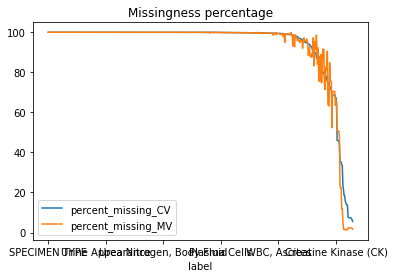

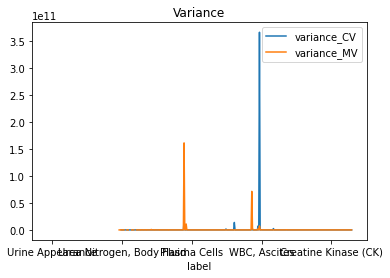

In [18]:
# # plotting the missingness rate and variance
missing_value_lab_both.plot(x='label', y=["percent_missing_CV", "percent_missing_MV"])
plt.title("Missingness percentage")
plt.show()
plt.close()

# missing_value_lab_both.plot(x='label', y=["percent_missing_CV", "percent_missing_MV"])
missing_value_lab_both.plot(x='label', y=["variance_CV", "variance_MV"], rot=0)
# ax = missing_value_lab_both.plot(
#     x='label', y=["percent_missing_CV", "percent_missing_MV"], linestyle='-', marker='o')
# missing_value_lab_both.plot(x='label', y=["variance_CV", "variance_MV"], kind='bar',ax=ax,  rot=0)
plt.title("Variance")
# plt.title("Missingness percentage, Variance")
plt.yscale('linear')
plt.show()
plt.close()

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_lab_both.sort_values(by='itemid', ascending=True))

label  percent_missing_CV  \
itemid                                                             
50800                          SPECIMEN TYPE          100.000000   
50801             Alveolar-arterial Gradient           89.759298   
50802                            Base Excess           45.907451   
50803    Calculated Bicarbonate, Whole Blood           98.323796   
50804                   Calculated Total CO2           45.898122   
50805                      Carboxyhemoglobin           99.508645   
50806                  Chloride, Whole Blood           89.927230   
50808                           Free Calcium           63.652196   
50809                                Glucose           72.331758   
50810                 Hematocrit, Calculated           78.007215   
50811                             Hemoglobin           78.007215   
50812                              Intubated          100.000000   
50813                                Lactate           69.377410   
50814                          Methemoglobin           99.555293   
50815                                O2 Flow           95.294813   
50816                                 Oxygen           73.062570   
50817                      Oxygen Saturation           70.702202   
50818                                   pCO2           45.904341   
50819                                   PEEP           82.482274   
50820                                     pH           43.942033   
50821                                    pO2           45.904341   
50822                 Potassium, Whole Blood           72.148277   
50823                            Required O2           89.749969   
50824                    Sodium, Whole Blood           80.877597   
50825                            Temperature           76.875233   
50826                           Tidal Volume           81.589750   
50827                       Ventilation Rate          100.000000   
50828                             Ventilator          100.000000   
50831                                     pH           99.782311   
50835                       Albumin, Ascites           99.863167   
50836                       Amylase, Ascites           99.856947   
50838              Bilirubin, Total, Ascites           99.903595   
50841                    Creatinine, Ascites           99.944023   
50842                       Glucose, Ascites           99.729444   
50843         Lactate Dehydrogenase, Ascites           99.707675   
50849                 Total Protein, Ascites           99.620600   
50850                 Triglycerides, Ascites           99.987561   
50852                       % Hemoglobin A1c           96.896380   
50856                          Acetaminophen           99.760542   
50857                                Acetone          100.000000   
50861         Alanine Aminotransferase (ALT)           73.948874   
50862                                Albumin           78.349297   
50863                   Alkaline Phosphatase           74.847618   
50864                      Alpha-Fetoprotein           99.723224   
50866                                Ammonia           99.238089   
50867                                Amylase           86.326036   
50868                              Anion Gap           16.056102   
50871            Anti-Mitochondrial Antibody          100.000000   
50872   Anti-Neutrophil Cytoplasmic Antibody          100.000000   
50873                  Anti-Nuclear Antibody          100.000000   
50874           Anti-Nuclear Antibody, Titer          100.000000   
50876            Anti-Smooth Muscle Antibody          100.000000   
50877          Anti-Thyroglobulin Antibodies          100.000000   
50878        Asparate Aminotransferase (AST)           73.967533   
50879                     Barbiturate Screen          100.000000   
50880                  Benzodiazepine Screen          100.000000   
50882                            Bicarbonate           13.733051   
50883                      

In [30]:
Mimic_lab_MV_Formatted_value[50861].value_counts()

18.0       235
14.0       220
17.0       218
20.0       215
15.0       211
          ... 
1123.0       1
455.0        1
3490.0       1
11800.0      1
826.0        1
Name: 50861, Length: 731, dtype: int64

In [25]:
len(missing_value_lab_both[(missing_value_lab_both['percent_missing_CV']<90) & (missing_value_lab_both['percent_missing_MV']<90)])

58

In [33]:
# Selecting only those that have missing value less than approximately 90 percent (58 in number)
Final_lab_itemids_used = list(missing_value_lab_both[(missing_value_lab_both['percent_missing_CV']<90) & (missing_value_lab_both['percent_missing_MV']<90)].index)

In [34]:
# Final lab dataset
Mimic_lab_CV_Formatted_value= Mimic_lab_CV_Formatted_value[Final_lab_itemids_used]
Mimic_lab_MV_Formatted_value=Mimic_lab_MV_Formatted_value[Final_lab_itemids_used]

In [35]:
# Lab data observations rows 
print('Care vue era lab admissions * labitems : ', Mimic_lab_CV_Formatted_value.shape)
print('Meta vision era lab admissions * labitems : ', Mimic_lab_MV_Formatted_value.shape)

Care vue era lab admissions * labitems :  (32156, 58)
Meta vision era lab admissions * labitems :  (21295, 58)


In [36]:
Mimic_lab_CV_Formatted_value.head()

itemid   50806  51214  51003  50954  50819  51498  50826  51491  50824  50862  \
hadm_id                                                                         
100006     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100007     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100017     NaN    NaN    NaN    NaN    NaN    NaN  800.0    NaN    NaN    4.1   
100021     NaN    NaN    NaN    NaN    NaN  1.014    NaN    8.0    NaN    NaN   
100023     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

itemid   ...  50902  51277  51279  51248  51250  51249  51222  51301  51265  \
hadm_id  ...                                                                  
100006   ...  103.0   14.9   3.13   32.8   98.0   33.5   10.3   13.6  204.0   
100007   ...  106.0   14.3   3.71   30.6   90.0   33.8   11.3    8.8  198.0   
100017   ...  104.0   12.9   4.53   31.6   91.0   34.5   14.3    9.3  173.0   
100021   ...  106.0   16.4   2.67   38.0  111.0   34.4   10.2    5.9   75.0   
100023   ...    NaN   16.8   4.77   35.4  107.0   33.2   16.9   17.7  318.0   

itemid   51221  
hadm_id         
100006    30.6  
100007    33.5  
100017    41.4  
100021    29.5  
100023    50.8  

[5 rows x 58 columns]

In [37]:
Mimic_lab_MV_Formatted_value.head()

itemid   50806  51214  51003  50954  50819  51498  50826  51491  50824  50862  \
hadm_id                                                                         
100001     NaN    NaN    NaN    NaN    NaN  1.006    NaN    6.5    NaN    NaN   
100003     NaN  191.0    NaN  408.0    NaN  1.016    NaN    5.5    NaN    2.3   
100009   104.0  186.0    NaN    NaN    NaN    NaN    NaN    NaN  139.0    NaN   
100010     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100011     NaN    NaN    NaN    NaN    5.0    NaN  550.0    NaN  138.0    NaN   

itemid   ...  50902  51277  51279  51248  51250  51249  51222  51301  51265  \
hadm_id  ...                                                                  
100001   ...  112.0   13.9   4.02   28.2   81.0   34.6   11.3   10.4  407.0   
100003   ...  111.0   20.1   3.17   31.6   91.0   34.6   10.0   14.2  162.0   
100009   ...  109.0   14.0   4.32   30.2   86.0   35.2   13.1   13.8  125.0   
100010   ...  107.0   15.3   3.75   26.0   78.0   33.4    9.7   15.0  347.0   
100011   ...  109.0   13.5   2.73   32.8   92.0   35.9    9.0    7.6  188.0   

itemid   51221  
hadm_id         
100001    32.8  
100003    29.5  
100009    37.1  
100010    25.5  
100011    25.0  

[5 rows x 58 columns]

In [38]:
# checking dtypes of the columns
Mimic_lab_MV_Formatted_value.dtypes

itemid
50806    float64
51214    float64
51003    float64
50954    float64
50819    float64
51498    float64
50826    float64
51491    float64
50824    float64
50862    float64
50911    float64
50810    float64
50811    float64
50825    float64
50863    float64
50878    float64
50861    float64
50816    float64
50809    float64
50822    float64
50817    float64
50813    float64
51146    float64
51200    float64
51256    float64
51244    float64
51254    float64
50885    float64
50910    float64
50808    float64
50802    float64
50821    float64
50818    float64
50804    float64
50820    float64
51275    float64
51237    float64
51274    float64
50893    float64
50970    float64
50960    float64
50931    float64
51006    float64
50912    float64
50868    float64
50971    float64
50983    float64
50882    float64
50902    float64
51277    float64
51279    float64
51248    float64
51250    float64
51249    float64
51222    float64
51301    float64
51265    float64
51221    float64
dtype: 

In [ ]:
# imputation on labs; mean imputation; since all variables are numeric so it should work fine.



## Processing chartevents

In [3]:
Mimic_chart_MV = pd.read_csv('mimic_chartevents_metavision.csv')
Mimic_chart_CV = pd.read_csv('mimic_chartevents_carevue.csv')

/home/trips/Virtual_env_python/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# These two icustays are extra for one hadm_id. Not sure how they got in.
Mimic_chart_MV = Mimic_chart_MV[Mimic_chart_MV['icustay_id'] != 281378]
Mimic_chart_CV = Mimic_chart_CV[Mimic_chart_CV['icustay_id'] != 244034] 

In [5]:
# It is known that error = 1 in Metavision had measurement errors so selecting observations containing only error=0 cases
Mimic_chart_MV = Mimic_chart_MV[Mimic_chart_MV['error']==0]

In [6]:
print("CV orig obs shape ",Mimic_chart_CV.shape)
print("MV orig obs shape ",Mimic_chart_MV.shape)

CV orig obs shape  (5728193, 17)
MV orig obs shape  (5089801, 17)


In [7]:
Mimic_chart_CV.head()

row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
0  34303794           2   163353    243653.0     211  2138-07-17 22:00:00   
1  34303795           2   163353    243653.0     834  2138-07-17 22:00:00   
2  34303796           2   163353    243653.0    3303  2138-07-17 22:00:00   
3  34303793           2   163353    243653.0    3412  2138-07-17 21:45:00   
4  34303791           2   163353    243653.0    3445  2138-07-17 21:30:00   

             storetime   cgid  value  valuenum valueuom  warning  error  \
0  2138-07-17 22:08:00  17774    140     140.0      bpm      NaN    NaN   
1  2138-07-17 22:08:00  17774     96      96.0        %      NaN    NaN   
2  2138-07-17 22:07:00  17774  Given       NaN      NaN      NaN    NaN   
3  2138-07-17 22:07:00  17774  Given       NaN      NaN      NaN    NaN   
4  2138-07-17 22:07:00  17774  Given       NaN      NaN      NaN    NaN   

  resultstatus   stopped  expire_flag dbsource  
0          NaN  NotStopd            0  carevue  
1          NaN  NotStopd            0  carevue  
2          NaN  NotStopd            0  carevue  
3          NaN  NotStopd            0  carevue  
4          NaN  NotStopd            0  carevue

In [8]:
Mimic_chart_MV.head()

row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
0        269          23   124321      234044  220045  2157-10-22 11:00:00   
1        217          23   124321      234044  220046  2157-10-22 08:00:00   
2        218          23   124321      234044  220047  2157-10-22 08:00:00   
3  261270077          23   124321      234044  220048  2157-10-22 11:00:00   
4        270          23   124321      234044  220050  2157-10-22 11:00:00   

             storetime     cgid              value  valuenum valueuom  \
0  2157-10-22 11:05:00  19907.0                 85      85.0      bpm   
1  2157-10-22 08:48:00  19907.0                120     120.0      bpm   
2  2157-10-22 08:48:00  19907.0                 50      50.0      bpm   
3  2157-10-22 11:05:00  19907.0  SR (Sinus Rhythm)       NaN      NaN   
4  2157-10-22 11:05:00  19907.0                128     128.0     mmHg   

   warning  error resultstatus stopped  expire_flag    dbsource  
0      0.0    0.0          NaN     NaN            0  metavision  
1      0.0    0.0          NaN     NaN            0  metavision  
2      0.0    0.0          NaN     NaN            0  metavision  
3      0.0    0.0          NaN     NaN            0  metavision  
4      0.0    0.0          NaN     NaN            0  metavision

In [37]:
Mimic_chart_CV.dtypes

row_id            int64
subject_id        int64
hadm_id           int64
icustay_id      float64
itemid            int64
charttime        object
storetime        object
cgid              int64
value            object
valuenum        float64
valueuom         object
warning         float64
error           float64
resultstatus     object
stopped          object
expire_flag       int64
dbsource         object
dtype: object

In [9]:
# Changing the data view to get it in the subjects in rows and items in columns
Mimic_chart_MV_Formatted_value = Mimic_chart_MV.pivot(index='hadm_id', columns='itemid', values='value')
Mimic_chart_CV_Formatted_value = Mimic_chart_CV.pivot(index='hadm_id', columns='itemid', values='value')

In [15]:
Mimic_chart_CV_Formatted_value

itemid  1      2      3      4      5      6      24     25     26      \
hadm_id                                                                  
100006     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100007     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100017     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100021     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100023     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...   
199988     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199993     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199994     25%    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199995     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199998     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

itemid           27      ... 227467 227468 227469 227470 227471 227516 227517  \
hadm_id                  ...                                                    
100006             Soft  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100007           Tender  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100017             Soft  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100021   Soft Distended  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100023              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                 ...  ...    ...    ...    ...    ...    ...    ...    ...   
199988   Soft Distended  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199993             Soft  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199994            Obese  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199995             Soft  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
199998             Soft  ...    1.1    402    NaN    NaN    NaN    NaN    NaN   

itemid  227565 227566 227686  
hadm_id                       
100006     NaN    NaN    NaN  
100007     NaN    NaN    NaN  
100017     NaN    NaN    NaN  
100021     NaN    NaN    NaN  
100023     NaN    NaN    NaN  
...        ...    ...    ...  
199988     NaN    NaN    NaN  
199993     NaN    NaN    NaN  
199994     NaN    NaN    NaN  
199995     NaN    NaN    NaN  
199998     NaN    NaN    NaN  

[33669 rows x 2896 columns]

In [13]:
Mimic_chart_MV_Formatted_value.head()

itemid  220045 220046 220047                   220048 220050 220051 220052  \
hadm_id                                                                      
100001     117    120     60  ST (Sinus Tachycardia)     NaN    NaN    NaN   
100003      80    120     50        SR (Sinus Rhythm)    NaN    NaN    NaN   
100009      58    120     60                  A Paced    132     54     75   
100010      98    120     50        SR (Sinus Rhythm)    100     55     71   
100011     102    120     50  ST (Sinus Tachycardia)     107     60     74   

itemid  220056 220058 220059  ... 228442 228443 228444 228445 228446 228447  \
hadm_id                       ...                                             
100001     NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
100003     NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
100009      90    140     35  ...    NaN    NaN    NaN    NaN    NaN    NaN   
100010      80    160    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
100011      90    160    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   

itemid  228448 228449 228450 228451  
hadm_id                              
100001     NaN    NaN    NaN    NaN  
100003     NaN    NaN    NaN    NaN  
100009     NaN    NaN    NaN    NaN  
100010     NaN    NaN    NaN    NaN  
100011     NaN    NaN    NaN    NaN  

[5 rows x 1538 columns]

In [14]:
# Getting the item ids that are metavision but used in carevue icustays
Common_Chart_list = list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns)))
len(Common_Chart_list)

145

In [40]:
# dropping the extra columns/itemids from metavision that appeared in carevue data
# Removing only from CV dataset (and not from MV dataset) because these columns originaly beong to Metavision
Mimic_chart_CV_Formatted_value.drop(columns=Common_Chart_list, inplace=True)

In [41]:
# check to make sure if there is any common itemid between two eras
if list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns))) ==[]:
    print(" No common itemid. All good here!")

 No common itemid. All good here!


In [42]:
# check to make sure if there is any common admission between two eras
if list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_chart_CV_Formatted_value.index))) ==[]:
        print(" No common hadm_id. All good here!")

 No common hadm_id. All good here!


In [43]:
print("CV formatted obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted obs shape ",Mimic_chart_MV_Formatted_value.shape)

CV formatted obs shape  (33669, 2751)
MV formatted obs shape  (21429, 1538)


In [44]:
# Selecting hadm_ids associate with patients older than 18 years
adult_hadmid_CV = list(set(Mimic_chart_CV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))
adult_hadmid_MV = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))

In [45]:
# selecting only adult patients in the dataset
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value.loc[adult_hadmid_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value.loc[adult_hadmid_MV]

In [46]:
print("CV formatted (ADULTS) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted (ADULTS) obs shape ",Mimic_chart_MV_Formatted_value.shape)

CV formatted (ADULTS) obs shape  (26383, 2751)
MV formatted (ADULTS) obs shape  (21401, 1538)


In [47]:
Mimic_chart_CV_Formatted_value.head()

itemid  1    2    3    4    5    6    24   25   26    27    ... 8538 8547  \
hadm_id                                                     ...             
131073   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131082   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131085   33%  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131086   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  105   
131087   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   

itemid  8548 8549 8550 8551 8552 8553 8554 8555  
hadm_id                                          
131073   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
131082   NaN  120  NaN   90  NaN   30  100  NaN  
131085   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
131086   NaN  120  NaN  105  NaN   30  100  NaN  
131087   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 2751 columns]

In [48]:
Mimic_chart_MV_Formatted_value.head()

itemid  220045 220046 220047                    220048 220050 220051 220052  \
hadm_id                                                                       
131072      73    120     55  AF (Atrial Fibrillation)    143     51     78   
196611      60    120     50         SR (Sinus Rhythm)     60     57     59   
131076      94    120     60         SR (Sinus Rhythm)    114     56     74   
131078      80    120     60         SR (Sinus Rhythm)    NaN    NaN    NaN   
163846       0    120     50  AF (Atrial Fibrillation)    NaN    NaN    NaN   

itemid  220056 220058 220059  ... 228442 228443 228444 228445 228446 228447  \
hadm_id                       ...                                             
131072     100    140    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
196611     NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
131076      90    140     33  ...    NaN    NaN    NaN    NaN    NaN    NaN   
131078     NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
163846     NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   

itemid  228448 228449 228450 228451  
hadm_id                              
131072     NaN    NaN    NaN    NaN  
196611     NaN    NaN    NaN    NaN  
131076     NaN    NaN    NaN    NaN  
131078     NaN    NaN    NaN    NaN  
163846     NaN    NaN    NaN    NaN  

[5 rows x 1538 columns]

In [49]:
# [print(i) for i in list(Mimic_chart_CV_Formatted_value.columns) if np.array_equal(Mimic_chart_CV_Formatted_value[i], Mimic_chart_CV_Formatted_value[i].astype(int))==True]
Mimic_chart_CV_Formatted_value.convert_dtypes().dtypes

1       string
2       string
3       string
4       string
5       string
         ...  
8551    string
8552    string
8553    string
8554    string
8555    string
Length: 2751, dtype: object

In [50]:
Mimic_chart_CV_Formatted_value.head()

itemid  1    2    3    4    5    6    24   25   26    27    ... 8538 8547  \
hadm_id                                                     ...             
131073   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131082   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131085   33%  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   
131086   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  105   
131087   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  Soft  ...  NaN  NaN   

itemid  8548 8549 8550 8551 8552 8553 8554 8555  
hadm_id                                          
131073   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
131082   NaN  120  NaN   90  NaN   30  100  NaN  
131085   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
131086   NaN  120  NaN  105  NaN   30  100  NaN  
131087   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 2751 columns]

In [51]:
# partitioning the list of variables in numeric and non-numeric; there are cases where the non-numerics are 
# actually numeric but due to someterms like error or no data they hav gone into non-numeric set.
initial_list_itemid_non_num_CV = []
list_itemid_num_CV = []
for i in Mimic_chart_CV_Formatted_value.columns:
    try :
        pd.to_numeric(Mimic_chart_CV_Formatted_value[i], downcast='float')
        list_itemid_num_CV.append(i)
    except ValueError:
        temp = pd.to_numeric(Mimic_chart_CV_Formatted_value[i].unique(), errors='coerce', downcast='float')
        if np.isnan(temp).sum()!=len(temp):
            list_itemid_num_CV.append(i)
        else:
            initial_list_itemid_non_num_CV.append(i)
        pass
print("Num of numeric variables ", len(list_itemid_num_CV))
print("Initial Num of non-numeric CV varibles ", len(initial_list_itemid_non_num_CV))

Num of numeric variables  1793
Initial Num of non-numeric CV varibles  958


In [52]:
# exploring the non-numeric Carevue era variables and selecting only those that have some categorical forms
ctr_cat = 0 
list_itemid_cat_CV = []  # decided as those that have less than 10 unique values
for i in initial_list_itemid_non_num_CV:
    if len(Mimic_chart_CV_Formatted_value[i].unique()) <= 10:
#         print(" Variable name and id ", item_id_dbsource[item_id_dbsource['itemid']==i]['label'], i)
#         print(Mimic_chart_CV_Formatted_value[i].unique(), "\n")
        list_itemid_cat_CV.append(i)
        ctr_cat = ctr_cat +1
print('Number of categoricals ', len(list_itemid_cat_CV))

Number of categoricals  834


In [53]:
# converting the numeric type variables for CV from string to float
for i in list_itemid_num_CV:
    Mimic_chart_CV_Formatted_value[i] = pd.to_numeric(Mimic_chart_CV_Formatted_value[i], errors='coerce')

In [215]:
# converting the numeric type variables for MV from string to float
list_itemid_num_MV = list(set(list_itemid_num_MV).intersection(set(Mimic_chart_MV_Formatted_value.columns)))
list_itemid_cat_MV = list(set(list_itemid_cat_MV).intersection(set(Mimic_chart_MV_Formatted_value.columns)))
for i in list_itemid_num_MV:
    Mimic_chart_MV_Formatted_value[i] = pd.to_numeric(Mimic_chart_MV_Formatted_value[i], errors='coerce')

In [230]:
# finding the missing ratio of all the Carevue columns to eliminate the ones that have very high missing ratio
percent_missing_CV = Mimic_chart_CV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_CV_Formatted_value)
Variance_CV_charts = Mimic_chart_CV_Formatted_value[list_itemid_num_CV].var().round(2)
missing_value_df_CV = pd.DataFrame({'column_name': Mimic_chart_CV_Formatted_value.columns,
                                 'percent_missing_CV': percent_missing_CV})
missing_value_df_CV.reset_index(inplace=True)
missing_value_df_CV = pd.merge(item_id_dbsource, missing_value_df_CV, how="inner", on=["itemid"])
missing_value_df_CV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_CV.set_index('itemid', inplace=True)
missing_value_df_CV.sort_values(by='percent_missing_CV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_df_CV)
    
# filtering out the columns by missingness percent 
# missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

row_id                                         label abbreviation  \
itemid                                                                      
3801      2902                                          SGOT          NaN   
3525      1101                               NICU Procedures          NaN   
3530      1103                            Narcotic Analgesic          NaN   
3531      1104                           Nares Patent [Left]          NaN   
3532      1105                              Nasal Congestion          NaN   
3536      1106                                Nasal Sx Color          NaN   
3537      1107                              Nasal Sx Quality          NaN   
3538      1108                             Nasal Sx Quantity          NaN   
3540      1110                                   Nipple Type          NaN   
3543      1111                             O2 Administration          NaN   
3544      1112                               O2 Analyzer Cal          NaN   
3545      1113                              O2 Sat W/Seizure          NaN   
3546      1114                             O2 Tubing Present          NaN   
3547      1115                                OG/NG Residual          NaN   
3548      1116                            Oral Abnormalities          NaN   
3549      1117                                 Oral Sx Color          NaN   
3550      1118                               Oral Sx Quality          NaN   
3551      1119                              Oral Sx Quantity          NaN   
3554      1121                                     Oxacillin          NaN   
3555      1122                                    PEEP Alarm          NaN   
3556      1123                                     PIP Alarm          NaN   
2921      3866                                       Delta P          NaN   
3448      1041                            Grandparents Visit          NaN   
3447      1040                             Glucose Monitor #          NaN   
3446      1039                               Gestational Age          NaN   
3445      1038                                    Gentamicin          NaN   
3444      1037                                     Genitalia          NaN   
3528      1102                                Na Bicarbonate          NaN   
3524      1100                                 NGT Placement          NaN   
3479      1066                                  Intervention          NaN   
3523      1099                             NG Tube Taped at:          NaN   
3476      1064                               Infant Position          NaN   
3475      1063                                 Infant ABO/Rh          NaN   
3474      1062                          Indomethacin/Indocin          NaN   
3472      1061                            Image Transmission          NaN   
3471      1060                                    IV Site #5          NaN   
3469      1059                              IV #5 [Location]          NaN   
3468      1058                              IV #4 [Location]          NaN   
3467      1057                              IV #3 [Location]          NaN   
3466      1056                              IV #2 [Location]          NaN   
3465      1055                              IV #1 [Location]          NaN   
3463      1054                                Hydrocortisone          NaN   
3460      1053                          Humidity Temp [Meas]          NaN   
3459      1052                          High Pressure Relief          NaN   
3458      1051                                   HiB Vaccine          NaN   
3457      1050                                         Hertz          NaN   
3456      1049                                Hernia [Right]          NaN   
3455      1048                                 Hernia [Left]          NaN   
3454      1047                                      Heptavax          NaN   
3453      1046                                   Head of Bed          NaN   
3452

## TODO add here
### Run a text clustering with numeric context if possible on the itemids label from cavevue to see if they can be combined 

In [277]:
# finding the missing ratio of all Metavision columns to eliminate the ones that have very high missing ratio
percent_missing_MV = Mimic_chart_MV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_MV_Formatted_value)
missing_value_df_MV = pd.DataFrame({'column_name': Mimic_chart_MV_Formatted_value.columns,
                                 'percent_missing_MV': percent_missing_MV})
missing_value_df_MV.reset_index(inplace=True)
missing_value_df_MV = pd.merge(item_id_dbsource, missing_value_df_MV, how="inner", on=["itemid"])
missing_value_df_MV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_MV.set_index('itemid', inplace=True)
missing_value_df_MV.sort_values(by='percent_missing_MV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(missing_value_df_MV)
    
# filtering out the columns by missingness percent 
# missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<40]

In [364]:
missing_value_df_MV[missing_value_df_MV.index.isin(final_itemids_chart_MV_bin)]

row_id                                              label  \
itemid                                                              
225188   13780                                  Cough/Deep Breath   
224564   13400                              Impaired Skin Odor #1   
225175   13772           See chart for initial patient assessment   
225086   13719            Unable to assess cognitive / perceptual   
225091   13722               Unable to assess activity / mobility   
225129   13742         Unable to assess teaching / learning needs   
225133   13744                                    Discharge needs   
225117   13735             Unable to assess nutrition / education   
228305   15438                           ST Segment Monitoring On   
226169   14285                              Subglottal Suctioning   
225070   13711                     Unable to assess psychological   
228099   15294                       18 Gauge placed in the field   
228100   15295                       20 Gauge placed in the field   
228236   15232                                       Insulin pump   
225210   13794                       Arterial Line Zero/Calibrate   
226107   14246           Arterial Line placed in outside facility   
227292   14623                   Arterial Line Dressing Occlusive   
225076   13714  Emotional / physical / sexual harm by partner ...   
227349   14863                      High risk (>51) interventions   
226180   14288                  Sexuality / reproductive problems   
225313   13690                                           Bed Bath   
225078   13715                                Social work consult   
225074   13713                          Any fear in relationships   
225124   13739                 Unintentional weight loss >10 lbs.   
225122   13738                                       Special diet   
225110   13732                              Recreational drug use   
225067   13710          Is the spokesperson the Health Care Proxy   
225184   13777                                           Eye Care   
226179   14287                                  No wallet / money   
226137   14274                18 Gauge placed in outside facility   
225126   13740                                   Dialysis patient   
227367   14881                        18 Gauge Dressing Occlusive   
225113   13734                        Currently experiencing pain   
225087   13720                           Visual / hearing deficit   
226138   14275                20 Gauge placed in outside facility   
225118   13736                              Difficulty swallowing   
225106   13730                                               ETOH   
227368   14882                        20 Gauge Dressing Occlusive   
225094   13724                           History of slips / falls   
225092   13723                                           Self ADL   
225185   13778                                          Skin Care   
225187   13779                                          Back Care   
225103   13728        Intravenous  / IV access prior to admission   
227688   15023  Smoking Cessation Info Offered through BIDMC I...   
224168   13051                                 Parameters Checked   
224641   13422                                          Alarms On   

                                             abbreviation      linksto  \
itemid                                                                   
225188                                  Cough/Deep Breath  chartevents   
224564                                            Odor #1  chartevents   
225175           See chart for initial patient assessment  chartevents   
225086            Unable to assess cognitive / perceptual  chartevents   
225091               Unable to assess activity / mobility  chartevents   
225129         Unable to assess teaching / learning needs  chartevents   
225133                                    Discharge needs  chartevents   
225117             Unable to 

In [307]:
# selecting only columns that have less than 80 percent missing values
final_itemids_chart_CV_num = list(missing_value_df_CV[(missing_value_df_CV.index.isin(list_itemid_num_CV)) & (missing_value_df_CV['percent_missing_CV']<80)].index)
final_itemids_chart_CV_cat = list(missing_value_df_CV[(missing_value_df_CV.index.isin(list_itemid_cat_CV)) & (missing_value_df_CV['percent_missing_CV']<80)].index)
# final_itemids_chart_CV_t = final_itemids_chart_CV_num + final_itemids_chart_CV_cat
final_itemids_chart_MV_num = list(missing_value_df_MV[(missing_value_df_MV.index.isin(list_itemid_num_MV)) & (missing_value_df_MV['percent_missing_MV']<80)].index)
final_itemids_chart_MV_cat = list(missing_value_df_MV[(missing_value_df_MV.index.isin(list_itemid_cat_MV)) & (missing_value_df_MV['percent_missing_MV']<80)].index)
# final_itemids_chart_MV_t = final_itemids_chart_MV_num + final_itemids_chart_MV_cat


final_itemids_chart_CV = missing_value_df_CV[(missing_value_df_CV.index.isin(list_itemid_num_CV + list_itemid_cat_CV)) & (missing_value_df_CV['percent_missing_CV']<80)].index
final_itemids_chart_MV = missing_value_df_MV[(missing_value_df_MV.index.isin(list_itemid_num_MV + list_itemid_cat_MV)) & (missing_value_df_MV['percent_missing_MV']<80)].index

In [288]:
# selecting only columns that have less than 80 percent missing values
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value[final_itemids_chart_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value[final_itemids_chart_MV]

In [289]:
print("CV formatted (ADULTS, less missing) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted (ADULTS, less missing) obs shape ",Mimic_chart_MV_Formatted_value.shape)

CV formatted (ADULTS, less missing) obs shape  (26383, 208)
MV formatted (ADULTS, less missing) obs shape  (21401, 148)


In [295]:
# checking the dtypes of different columns
Mimic_chart_MV_Formatted_value.dtypes == 'object'

46

In [291]:
# Final hadm_ids common between lab and chartevents
final_hadmid_CV = list(set(Mimic_chart_CV_Formatted_value.index).intersection(set(Mimic_lab_CV_Formatted_value.index)))
final_hadmid_MV = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_lab_MV_Formatted_value.index)))

In [292]:
# Final dataset Chartevents that has common hadm_ids with labevents dataset
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value.loc[final_hadmid_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value.loc[final_hadmid_MV]

In [347]:
# Final dataset labevents  that has common hadm_ids with chartevents dataset
Mimic_lab_CV_Formatted_value = Mimic_lab_CV_Formatted_value.loc[final_hadmid_CV]
Mimic_lab_MV_Formatted_value = Mimic_lab_MV_Formatted_value.loc[final_hadmid_MV]

In [348]:
print("Chart CV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("Chart MV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_chart_MV_Formatted_value.shape)

Chart CV formatted (ADULTS, less missing, common with labs) obs shape  (26130, 208)
Chart MV formatted (ADULTS, less missing, common with labs) obs shape  (21125, 148)


In [349]:
print("Lab CV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_lab_CV_Formatted_value.shape)
print("Lab MV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_lab_MV_Formatted_value.shape)

Lab CV formatted (ADULTS, less missing, common with labs) obs shape  (26130, 58)
Lab MV formatted (ADULTS, less missing, common with labs) obs shape  (21125, 58)


In [363]:
# check if there are any bianry variables before converting to dummies
if sum([len(Mimic_chart_CV_Formatted_value[i].value_counts()) < 3 for i in final_itemids_chart_CV_cat]) ==0:
    print(" No binary variables in CV")
else:
    print(" Binary variables in CV")
    final_itemids_chart_CV_bin = [i for i in final_itemids_chart_CV_cat if len(Mimic_chart_CV_Formatted_value[i].value_counts()) < 3]
    print(final_itemids_chart_CV_bin)
    print(" Num ofbin in CV ", len(final_itemids_chart_CV_bin))
if sum([len(Mimic_chart_MV_Formatted_value[i].value_counts()) < 3 for i in final_itemids_chart_MV_cat]) ==0:
    print(" No binary variables in MV")
else:
    print(" Binary variables in MV")
    final_itemids_chart_MV_bin = [i for i in final_itemids_chart_MV_cat if len(Mimic_chart_MV_Formatted_value[i].value_counts()) < 3]
    print(final_itemids_chart_MV_bin)
    print(" Num ofbin in MV ", len(final_itemids_chart_MV_bin))

 Binary variables in CV
[1517, 169, 1484, 1623]
 Num ofbin in CV  4
 Binary variables in MV
[225188, 224564, 225175, 225086, 225091, 225129, 225133, 225117, 228305, 226169, 225070, 228099, 228100, 228236, 225210, 226107, 227292, 225076, 227349, 226180, 225313, 225078, 225074, 225124, 225122, 225110, 225067, 225184, 226179, 226137, 225126, 227367, 225113, 225087, 226138, 225118, 225106, 227368, 225094, 225092, 225185, 225187, 225103, 227688, 224168, 224641]
 Num ofbin in MV  46


In [319]:
# One hot encoding the categoricals
Mimic_chart_CV_ohe = pd.get_dummies(Mimic_chart_CV_Formatted_value[final_itemids_chart_CV_cat])
Mimic_chart_MV_ohe = pd.get_dummies(Mimic_chart_MV_Formatted_value[final_itemids_chart_MV_cat])

In [341]:
# imputing the numeric variables; not correct because it should be done after train test split
Mimic_chart_CV_num_imp = Mimic_chart_CV_Formatted_value[final_itemids_chart_CV_num].fillna(Mimic_chart_CV_Formatted_value[final_itemids_chart_CV_num].mean())
Mimic_chart_MV_num_imp = Mimic_chart_MV_Formatted_value[final_itemids_chart_MV_num].fillna(Mimic_chart_MV_Formatted_value[final_itemids_chart_MV_num].mean())

In [345]:
# normalizing the numeric variables
(Mimic_chart_CV_num_imp-Mimic_chart_CV_num_imp.mean(axis=0))/Mimic_chart_CV_num_imp.std(axis=0)

itemid           8448      800           799           798   797   \
hadm_id                                                             
131073  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131082  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131085  -1.027835e+00  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131086  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131087  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
...               ...       ...           ...           ...   ...   
131056  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131057   2.938447e+00  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131059  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131062  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   
131068  -1.083928e-15  0.000001 -2.900983e-07 -3.935253e-07   0.0   

itemid           796           1538      6207          6206      114   ...  \
hadm_id                                                                ...   
131073   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  0.000002  ...   
131082   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  0.000002  ...   
131085   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  0.000002  ...   
131086   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  0.000002  ...   
131087   7.762202e-08 -6.112471e-01  0.000000  8.948866e-16  0.872152  ...   
...               ...           ...       ...           ...       ...  ...   
131056   7.762202e-08  5.684983e-08  2.995346  2.241562e+00  0.000002  ...   
131057   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  1.132935  ...   
131059   7.762202e-08  2.094422e+01  0.000000  8.948866e-16  0.000002  ...   
131062   7.762202e-08 -8.666711e-02  0.000000  8.948866e-16  0.000002  ...   
131068   7.762202e-08  5.684983e-08  0.000000  8.948866e-16  3.100955  ...   

itemid       837       781       791       829       813       646       198   \
hadm_id                                                                         
131073  -0.667325 -0.184300 -0.181990 -0.356762 -1.384636 -0.626821  0.603481   
131082   1.902586 -0.632627 -0.283222 -0.568082  0.191716 -0.409665  0.603481   
131085  -0.200068 -0.632627 -0.114502  0.488517  1.062857 -1.061134  0.603481   
131086   0.267188 -0.632627 -0.114502 -0.251102  0.855443 -0.409665  0.603481   
131087   0.500816  0.712352 -0.114502  0.171538  0.440613  0.024648 -1.216691   
...           ...       ...       ...       ...       ...       ...       ...   
131056  -0.200068 -0.682441 -0.181990 -0.356762  0.253940  0.241804 -0.609967   
131057   0.267188 -0.084672  0.087961  0.382857  0.959150 -0.409665  0.603481   
131059  -0.667325 -0.134486 -0.181990 -0.568082 -1.073514 -0.843978  0.603481   
131062   0.734445 -0.632627 -0.283222 -0.251102 -0.409787  0.676117  0.603481   
131068   1.201701 -0.433370 -0.215734 -0.462422  1.187306  0.241804 -1.216691   

itemid       618       211   742   
hadm_id                            
131073   0.323354 -0.427338   NaN  
131082  -0.395801 -0.600383   NaN  
131085   2.301028 -0.138930   NaN  
131086  -1.114955 -0.081248   NaN  
131087  -0.935167  2.283696   NaN  
...           ...       ...   ...  
131056  -1.834110  0.495567   NaN  
131057  -1.654321 -0.138930   NaN  
131059  -0.575589 -0.081248   NaN  
131062   0.143565 -1.407925   NaN  
131068   0.143565  1.014701   NaN  

[26130 rows x 113 columns]

In [352]:
# concatenating the lab and chartevent data from two eras
Mimic_lab_chart_CV = pd.concat([Mimic_lab_CV_Formatted_value, Mimic_chart_CV_Formatted_value], axis=1)
Mimic_lab_chart_MV = pd.concat([Mimic_lab_MV_Formatted_value, Mimic_chart_MV_Formatted_value], axis=1)

In [359]:
Mimic_chart_MV_Formatted_value[224641].value_counts()

1    20941
0       49
Name: 224641, dtype: int64

In [354]:
Mimic_lab_chart_MV

itemid   50806   51214   51003   50954   50819   51498   50826   51491   \
hadm_id                                                                   
131072      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
196611      NaN     NaN     NaN     NaN     5.0   1.025   550.0     6.0   
131076      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
131078      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
163847      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
163828      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
196596      NaN     NaN     NaN   561.0     NaN     NaN     NaN     NaN   
163833      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
196602      NaN     NaN     NaN     NaN     NaN   1.011     NaN     5.0   
163839      NaN     NaN    0.13     NaN     NaN     NaN     NaN     NaN   

itemid   50824   50862   ...  224161  223769  223770  220046  220047  224168  \
hadm_id                  ...                                                   
131072      NaN     NaN  ...    34.0   100.0    92.0   120.0    55.0       1   
196611      NaN     NaN  ...    30.0   100.0    90.0   120.0    50.0       1   
131076    139.0     NaN  ...    40.0   100.0    90.0   120.0    60.0       1   
131078      NaN     NaN  ...    30.0   100.0    90.0   120.0    60.0       1   
163847      NaN     NaN  ...    30.0   100.0    90.0   120.0    60.0       1   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
163828      NaN     2.5  ...    30.0   100.0    90.0   120.0    50.0       1   
196596    128.0     1.9  ...    35.0   100.0    92.0   120.0    50.0       1   
163833      NaN     NaN  ...    30.0   100.0    90.0   120.0    50.0       1   
196602      NaN     3.0  ...    35.0   100.0    92.0   130.0    60.0       1   
163839      NaN     NaN  ...    30.0   100.0    90.0   120.0    50.0       1   

itemid   220277  220210  224641  220045  
hadm_id                                  
131072     97.0    23.0       1    73.0  
196611     87.0    25.0       1    60.0  
131076     95.0    27.0       1    94.0  
131078    100.0    19.0       1    80.0  
163847     95.0    13.0       1    62.0  
...         ...     ...     ...     ...  
163828     97.0    17.0       1    68.0  
196596     91.0    19.0       1    99.0  
163833     99.0    22.0       1    92.0  
196602    100.0    14.0       1    92.0  
163839     99.0    21.0       1    96.0  

[21125 rows x 206 columns]

In [355]:
# Saving the datasets that still need imputation and standardization and one hot encoding too
Mimic_lab_chart_CV.to_csv('Final_MIMIC_lab_chart_CV.csv')
Mimic_lab_chart_MV.to_csv('Final_MIMIC_lab_chart_MV.csv')

## Extra Calculations for sanity check etc

### Current values are the dataset of only valuenum and hence a lot of nans

In [42]:
chart_MV = pd.merge(item_id_dbsource, Mimic_chart_MV_up, how="inner", on=["itemid"])
chart_CV = pd.merge(item_id_dbsource, Mimic_chart_CV, how="inner", on=["itemid"])

In [20]:
chart_MV

itemid                                     label  dbsource_x  \
0        225175  See chart for initial patient assessment  metavision   
1        225175  See chart for initial patient assessment  metavision   
2        225175  See chart for initial patient assessment  metavision   
3        225175  See chart for initial patient assessment  metavision   
4        225175  See chart for initial patient assessment  metavision   
...         ...                                       ...         ...   
5084870  226761                   HematocritApacheIIScore  metavision   
5084871  226761                   HematocritApacheIIScore  metavision   
5084872  226761                   HematocritApacheIIScore  metavision   
5084873  226761                   HematocritApacheIIScore  metavision   
5084874  226761                   HematocritApacheIIScore  metavision   

            row_id  subject_id  hadm_id  icustay_id            charttime  \
0        255619613          23   124321      234044  2157-10-21 16:35:00   
1        255620279         107   174162      264253  2122-05-15 06:37:00   
2        255622215         109   113189      291270  2142-02-14 14:27:00   
3        255621391         109   125288      257134  2141-11-18 22:27:00   
4        255622471         109   151240      219154  2142-05-15 16:09:00   
...            ...         ...      ...         ...                  ...   
5084870    2658463       22792   192087      271490  2173-10-23 07:07:00   
5084871    3301384       27366   174736      248077  2143-03-01 11:24:00   
5084872    3794758       28819   135454      212633  2116-02-11 02:18:00   
5084873    3887396       29070   115071      232563  2145-03-13 17:50:00   
5084874    7552740       44451   149944      296790  2125-01-08 22:14:00   

                   storetime     cgid value  valuenum valueuom  warning  \
0        2157-10-21 16:38:00  16978.0     1       1.0      NaN      0.0   
1        2122-05-15 06:37:00  16704.0     1       1.0      NaN      0.0   
2        2142-02-14 14:27:00  19079.0     1       1.0      NaN      0.0   
3        2141-11-18 22:27:00  19152.0     1       1.0      NaN      0.0   
4        2142-05-15 16:11:00  14542.0     1       1.0      NaN      0.0   
...                      ...      ...   ...       ...      ...      ...   
5084870  2173-10-23 07:08:00  15511.0     2       2.0      NaN      0.0   
5084871  2143-03-01 11:25:00  15237.0     0       0.0      NaN      0.0   
5084872  2116-02-11 02:20:00  19006.0     0       0.0      NaN      0.0   
5084873  2145-03-13 17:51:00  15052.0     2       2.0      NaN      0.0   
5084874  2125-01-08 22:14:00  14477.0     0       0.0      NaN      0.0   

         error resultstatus stopped  expire_flag  dbsource_y  
0          0.0          NaN     NaN            0  metavision  
1          0.0          NaN     NaN            0  metavision  
2          0.0          NaN     NaN            1  metavision  
3          0.0          NaN     NaN            1  metavision  
4          0.0          NaN     NaN            1  metavision  
...        ...          ...     ...          ...         ...  
5084870    0.0          NaN     NaN            0  metavision  
5084871    0.0          NaN     NaN            1  metavision  
5084872    0.0          NaN     NaN            1  metavision  
5084873    0.0          NaN     NaN            1  metavision  
5084874    0.0          NaN     NaN            0  metavision  

[5084875 rows x 19 columns]

In [21]:
chart_CV

itemid                                        label  dbsource_x  \
0           497  Patient controlled analgesia (PCA) [Inject]     carevue   
1           497  Patient controlled analgesia (PCA) [Inject]     carevue   
2           497  Patient controlled analgesia (PCA) [Inject]     carevue   
3           497  Patient controlled analgesia (PCA) [Inject]     carevue   
4           497  Patient controlled analgesia (PCA) [Inject]     carevue   
...         ...                                          ...         ...   
5728213  223837                                ETT Size (ID)  metavision   
5728214  223838                                 ETT Location  metavision   
5728215  225280                                   Called Out  metavision   
5728216  225280                                   Called Out  metavision   
5728217  225059                         Past medical history  metavision   

            row_id  subject_id  hadm_id  icustay_id            charttime  \
0        193152470           6   107064    228232.0  2175-05-31 21:00:00   
1        193177879          43   146828    225852.0  2186-10-02 23:00:00   
2        193179908          45   157907    274249.0  2129-06-11 00:00:00   
3        193275558         138   105764    294958.0  2134-03-02 08:00:00   
4        193348833         178   196159    297704.0  2163-01-08 15:00:00   
...            ...         ...      ...         ...                  ...   
5728213  269304537       30566   162451    283366.0  2163-02-18 14:00:00   
5728214  269304538       30566   162451    283366.0  2163-02-18 14:00:00   
5728215  256231922       29453   157477    211615.0  2138-09-16 10:00:00   
5728216  260397717       89327   163844    206931.0  2124-08-08 09:59:00   
5728217  266821876       27043   185347    288914.0  2141-06-22 18:31:00   

                   storetime   cgid   value  valuenum valueuom  warning  \
0        2175-05-31 23:08:00  15816      24      24.0      NaN      NaN   
1        2186-10-03 00:37:00  17155       1       1.0      NaN      NaN   
2        2129-06-11 01:02:00  20112       2       2.0      NaN      NaN   
3        2134-03-02 08:10:00  15048      10      10.0      NaN      NaN   
4        2163-01-08 14:58:00  14518       0       0.0      NaN      NaN   
...                      ...    ...     ...       ...      ...      ...   
5728213  2163-02-18 14:41:00  15012     8mm       NaN      NaN      0.0   
5728214  2163-02-18 14:41:00  15012  Oral-L       NaN      NaN      0.0   
5728215  2138-09-16 10:00:00  20101       1       1.0      NaN      0.0   
5728216  2124-08-08 09:59:00  20101       1       1.0      NaN      0.0   
5728217  2141-06-22 18:35:00  20345    ETOH       NaN      NaN      0.0   

         error resultstatus   stopped  expire_flag dbsource_y  
0          NaN          NaN  NotStopd            0    carevue  
1          NaN          NaN  NotStopd            0    carevue  
2          NaN          NaN  NotStopd            0    carevue  
3          NaN          NaN  NotStopd            0    carevue  
4          NaN          NaN  NotStopd            0    carevue  
...        ...          ...       ...          ...        ...  
5728213    0.0          NaN       NaN            0    carevue  
5728214    0.0          NaN       NaN            0    carevue  
5728215    0.0          NaN       NaN            0    carevue  
5728216    0.0          NaN       NaN            0    carevue  
5728217    0.0          NaN       NaN            1    carevue  

[5728218 rows x 19 columns]

In [22]:
usefulchart_patient_dbsource = chart_CV.groupby(['subject_id', 'dbsource_x']).size().reset_index(name='counts')

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(usefulchart_patient_dbsource)

       subject_id  dbsource_x  counts
0               2     carevue       7
1               3     carevue     231
2               4     carevue     151
3               5     carevue      20
4               6     carevue     163
5               8     carevue     139
6               9     carevue     225
7              10     carevue      85
8              11     carevue     150
9              12     carevue     213
10             13     carevue     270
11             16     carevue      29
12             17     carevue     501
13             18     carevue     127
14             19     carevue     158
15             20     carevue     233
16             21     carevue     450
17             22     carevue     138
18             23     carevue     288
19             24     carevue     109
20             25     carevue     200
21             26     carevue     137
22             27     carevue      31
23             28     carevue     264
24             30     carevue      99
25          

In [24]:
chart_CV[chart_CV['dbsource_x']!=chart_CV['dbsource_y']]

itemid                 label  dbsource_x     row_id  subject_id  \
5654255  227073             Anion gap  metavision       3179         109   
5654256  227073             Anion gap  metavision       3221         109   
5654257  227073             Anion gap  metavision      16032         124   
5654258  227073             Anion gap  metavision      37919         191   
5654259  227073             Anion gap  metavision      41260         222   
...         ...                   ...         ...        ...         ...   
5728213  223837         ETT Size (ID)  metavision  269304537       30566   
5728214  223838          ETT Location  metavision  269304538       30566   
5728215  225280            Called Out  metavision  256231922       29453   
5728216  225280            Called Out  metavision  260397717       89327   
5728217  225059  Past medical history  metavision  266821876       27043   

         hadm_id  icustay_id            charttime            storetime   cgid  \
5654255   166018    241668.0  2141-03-28 05:10:00  2141-03-28 06:16:00  20889   
5654256   170149    266497.0  2141-05-25 12:28:00  2141-05-25 18:09:00  20889   
5654257   134369    225073.0  2165-05-31 01:12:00  2165-05-31 02:04:00  20889   
5654258   136614    280149.0  2196-04-10 05:22:00  2196-04-10 06:39:00  20889   
5654259   137006    232363.0  2142-06-12 02:05:00  2142-06-12 02:58:00  20889   
...          ...         ...                  ...                  ...    ...   
5728213   162451    283366.0  2163-02-18 14:00:00  2163-02-18 14:41:00  15012   
5728214   162451    283366.0  2163-02-18 14:00:00  2163-02-18 14:41:00  15012   
5728215   157477    211615.0  2138-09-16 10:00:00  2138-09-16 10:00:00  20101   
5728216   163844    206931.0  2124-08-08 09:59:00  2124-08-08 09:59:00  20101   
5728217   185347    288914.0  2141-06-22 18:31:00  2141-06-22 18:35:00  20345   

          value  valuenum valueuom  warning  error resultstatus stopped  \
5654255      15      15.0    mEq/L      0.0    0.0          NaN     NaN   
5654256      22      22.0    mEq/L      1.0    0.0          NaN     NaN   
5654257      14      14.0    mEq/L      0.0    0.0          NaN     NaN   
5654258      15      15.0    mEq/L      0.0    0.0          NaN     NaN   
5654259      12      12.0    mEq/L      0.0    0.0          NaN     NaN   
...         ...       ...      ...      ...    ...          ...     ...   
5728213     8mm       NaN      NaN      0.0    0.0          NaN     NaN   
5728214  Oral-L       NaN      NaN      0.0    0.0          NaN     NaN   
5728215       1       1.0      NaN      0.0    0.0          NaN     NaN   
5728216       1       1.0      NaN      0.0    0.0          NaN     NaN   
5728217    ETOH       NaN      NaN      0.0    0.0          NaN     NaN   

         expire_flag dbsource_y  
5654255            1    carevue  
5654256            1    carevue  
5654257            1    carevue  
5654258            0    carevue  
5654259            1    carevue  
...              ...        ...  
5728213            0    carevue  
5728214            0    carevue  
5728215            0    carevue  
5728216            0    carevue  
5728217            1    carevue  

[73963 rows x 19 columns]

In [37]:
t_chartCV = Mimic_chart_CV.groupby(['hadm_id','icustay_id']).size().reset_index(name='counts').sort_values(by='hadm_id')
t_chartMV = Mimic_chart_MV.groupby(['hadm_id','icustay_id']).size().reset_index(name='counts').sort_values(by='hadm_id')

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(Mimic_chart_CV.groupby(['hadm_id','icustay_id']).size().reset_index(name='counts').sort_values(by='hadm_id'))

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(t_chartCV['hadm_id'].value_counts())
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(t_chartMV['hadm_id'].value_counts())

135166    1
197641    1
189910    1
126423    1
105945    1
165338    1
167387    1
179677    1
151011    1
163301    1
159207    1
198122    1
199590    1
169617    1
120304    1
118259    1
194036    1
196085    1
189942    1
101883    1
114173    1
108030    1
110079    1
155137    1
148994    1
151043    1
138761    1
132618    1
144908    1
140814    1
177813    1
196053    1
120272    1
181778    1
140750    1
122257    1
181650    1
118163    1
128404    1
195989    1
191895    1
167323    1
179613    1
167841    1
187620    1
148898    1
157094    1
176301    1
138665    1
134571    1
146861    1
120240    1
122289    1
196021    1
124342    1
126391    1
171449    1
166196    1
112060    1
107966    1
175551    1
159175    1
198090    1
170294    1
122385    1
183827    1
186000    1
124502    1
104024    1
171609    1
165466    1
179805    1
173662    1
175711    1
149090    1
157286    1
159335    1
195029    1
138857    1
134763    1
188374    1
142959    1
171755    1
1224

In [41]:
Mimic_chart_CV.groupby(['icustay_id']).size().reset_index(name='counts')

icustay_id  counts
0          200003     216
1          200006     165
2          200007     113
3          200009     257
4          200012     114
...           ...     ...
33654      299988     301
33655      299992     279
33656      299993     188
33657      299995     261
33658      299999     264

[33659 rows x 2 columns]

In [10]:
Mimic_chart_CV.groupby(['subject_id']).size().reset_index(name='counts')

subject_id  counts
0               2       7
1               3     231
2               4     151
3               5      20
4               6     163
...           ...     ...
28849       87186      25
28850       88500      26
28851       89327      35
28852       93571      32
28853       94537      42

[28854 rows x 2 columns]

In [27]:
a1= list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns)))

In [17]:
item_id_dbsource=pd.read_csv('./d_items_chartevents.csv')

In [18]:
item_id_dbsource

itemid                                        label    dbsource
0        497  Patient controlled analgesia (PCA) [Inject]     carevue
1        498                            PCA Lockout (Min)     carevue
2        499                               PCA Medication     carevue
3        500                               PCA Total Dose     carevue
4        501                           PCV Exh Vt (Obser)     carevue
...      ...                                          ...         ...
7207  226757                        GCSMotorApacheIIValue  metavision
7208  226758                       GCSVerbalApacheIIValue  metavision
7209  226759                            HCO3ApacheIIValue  metavision
7210  226760                                    HCO3Score  metavision
7211  226761                      HematocritApacheIIScore  metavision

[7212 rows x 3 columns]

In [25]:
temp_CV = Mimic_chart_CV.groupby(['itemid']).size().reset_index(name='counts')
temp_MV = Mimic_chart_MV_up.groupby(['itemid']).size().reset_index(name='counts')

In [64]:
b_MV = pd.merge(item_id_dbsource, temp_MV, how="inner", on=["itemid"])
b_CV = pd.merge(item_id_dbsource, temp_CV, how="inner", on=["itemid"])

In [76]:
useful_propMMV = b_MV[b_MV['itemid'].isin(a1)]
useful_propMMV['Perc of hadmids in MV icustays'] = np.round(useful_propMMV['counts']*100/len(Mimic_chart_MV_Formatted_value), decimals=2)

/home/trips/Virtual_env_python/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
useful_propMMV.drop(columns='dbsource', inplace=True)
useful_propMMV.drop(columns='counts', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(useful_propMMV)

      itemid                                        label  Perc Pts in MV icu
24    227073                                    Anion gap               97.01
132   227378                             Patient Location               72.21
142   226814                   Known difficult intubation               19.28
143   226815                              Airway problems                0.13
171   223679                           TCO2 (calc) Venous                5.79
338   227516                           PO2 (Mixed Venous)                3.01
339   227517                               Humidification               36.57
404   224684                           Tidal Volume (set)               35.40
405   224685                      Tidal Volume (observed)               39.86
406   224686                   Tidal Volume (spontaneous)               28.39
407   224687                                Minute Volume               40.07
408   224688                       Respiratory Rate (Set)       

/home/trips/Virtual_env_python/lib64/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
useful_propMV = b_CV[b_CV['itemid'].isin(a1)]

In [67]:
useful_propMV['Perc of hadmids in CV icustays'] = np.round(useful_propMV['counts']*100/len(Mimic_chart_CV_Formatted_value), decimals=2)

/home/trips/Virtual_env_python/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
useful_propMV.drop(columns='Fraction of hadmids', inplace=True)

KeyError: "['Fraction of hadmids'] not found in axis"

In [73]:
# useful_propMV.drop(columns='dbsource', inplace=True)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
useful_propMV.rename(columns={"Perc of hadmids in CV icustays": "Perc Pts in CV icu"}, inplace=True)

/home/trips/Virtual_env_python/lib64/python3.6/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [75]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(useful_propMV)

      itemid                                        label  Perc Pts in CV icu
2751  227073                                    Anion gap                6.80
2752  227378                             Patient Location                4.45
2753  226814                   Known difficult intubation                0.00
2754  226815                              Airway problems                0.00
2755  223679                           TCO2 (calc) Venous                0.19
2756  227516                           PO2 (Mixed Venous)                0.53
2757  227517                               Humidification                0.00
2758  224684                           Tidal Volume (set)                0.00
2759  224685                      Tidal Volume (observed)                0.00
2760  224686                   Tidal Volume (spontaneous)                0.00
2761  224687                                Minute Volume                0.00
2762  224688                       Respiratory Rate (Set)       

In [86]:
list(useful_propMV['label'])

['Anion gap',
 'Patient Location',
 'Known difficult intubation',
 'Airway problems',
 'TCO2 (calc) Venous',
 'PO2 (Mixed Venous)',
 'Humidification',
 'Tidal Volume (set)',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Minute Volume',
 'Respiratory Rate (Set)',
 'Respiratory Rate (spontaneous)',
 'Respiratory Rate (Total)',
 'Flow Pattern',
 'Mean Airway Pressure',
 'PSV Level',
 'Troponin-T',
 'Digoxin',
 'LDL measured',
 'Potassium (serum)',
 'HCO3 (serum)',
 'C Reactive Protein (CRP)',
 'CK-MB',
 'Brain Natiuretic Peptide (BNP)',
 'Gentamicin (Random)',
 'Gentamicin (Peak)',
 'Gentamicin (Trough)',
 'Vancomycin (Random)',
 'Vancomycin (Trough)',
 'Albumin',
 'Platelet Count',
 'CV - past medical history',
 'Ventilator Tank #1',
 'Ventilator Tank #2',
 'Phenobarbital',
 'Phenytoin (Dilantin)',
 'FK506',
 'Cortisol',
 'Potassium (whole blood)',
 'Prothrombin time',
 'PTT',
 'INR',
 'Fibrinogen',
 'Thrombin',
 'Sed Rate',
 'Specific Gravity (urine)',
 'ETT Mark (cm)',
 

In [43]:
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_up.pivot(index='hadm_id', columns='itemid', values='valuenum')
Mimic_chart_CV_Formatted_value = Mimic_chart_CV.pivot(index='hadm_id', columns='itemid', values='valuenum')

In [44]:
a = list(Mimic_chart_MV_Formatted_value.columns)
len(a)

1538

In [45]:
Mimic_chart_CV_Formatted_value

itemid   1       2       3       4       5       6       24      25      \
hadm_id                                                                   
100006      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100007      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100017      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100021      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100023      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199988      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199993      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199994      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199995      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199998      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

itemid   26      27      ...  227467  227468  227469  227470  227471  227516  \
hadm_id                  ...                                                   
100006      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100007      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100017      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100021      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100023      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199988      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199993      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199994      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199995      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199998      NaN     NaN  ...     1.1   402.0     NaN     NaN     NaN     NaN   

itemid   227517  227565  227566  227686  
hadm_id                                  
100006      NaN     NaN     NaN     NaN  
100007      NaN     NaN     NaN     NaN  
100017      NaN     NaN     NaN     NaN  
100021      NaN     NaN     NaN     NaN  
100023      NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199988      NaN     NaN     NaN     NaN  
199993      NaN     NaN     NaN     NaN  
199994      NaN     NaN     NaN     NaN  
199995      NaN     NaN     NaN     NaN  
199998      NaN     NaN     NaN     NaN  

[33669 rows x 2896 columns]

In [46]:
a1= list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns)))

In [47]:
a1

[225280,
 225811,
 220179,
 220180,
 227378,
 224828,
 224829,
 224830,
 224831,
 224832,
 220224,
 220734,
 220227,
 220228,
 220235,
 226381,
 223830,
 223837,
 223838,
 224865,
 227429,
 223848,
 223849,
 227440,
 227441,
 227442,
 227443,
 227444,
 227445,
 227446,
 227447,
 227448,
 227449,
 220274,
 227454,
 227455,
 223872,
 223873,
 223874,
 223875,
 223876,
 227456,
 227457,
 227460,
 227461,
 227462,
 227463,
 227464,
 227465,
 227466,
 227467,
 227468,
 227469,
 227470,
 227471,
 224415,
 224417,
 224421,
 224422,
 220339,
 227516,
 227517,
 226504,
 226512,
 226534,
 226536,
 226537,
 226540,
 227565,
 227566,
 226543,
 226544,
 226545,
 227073,
 226062,
 226063,
 225059,
 225072,
 225074,
 225612,
 225103,
 225106,
 225108,
 225624,
 225625,
 225628,
 225634,
 225636,
 225637,
 225126,
 225638,
 225639,
 225640,
 225641,
 225642,
 225643,
 227686,
 225651,
 220292,
 220293,
 220545,
 220546,
 225667,
 225668,
 225671,
 225672,
 224650,
 225674,
 225677,
 220048,
 225684,
 

In [73]:
max(a)

228451

In [74]:
b = list(Mimic_chart_CV_Formatted_value.columns)
max(b)

227686

In [8]:
percent_missing = (1-Mimic_chart_CV_Formatted_value.isnull().sum() / len(Mimic_chart_CV_Formatted_value))*100
missing_value_df = pd.DataFrame({'column_name': Mimic_chart_CV_Formatted_value.columns,
                                 'percent_missing': percent_missing})

In [9]:
missing_value_df

column_name  percent_missing
itemid                              
1                 1         0.000000
2                 2         0.228738
3                 3         0.231708
4                 4         0.231708
5                 5         0.234679
...             ...              ...
227516       227516         0.525800
227517       227517         0.000000
227565       227565         0.002971
227566       227566         0.002971
227686       227686         0.017824

[2896 rows x 2 columns]

In [37]:
Mimic_chart_MV_Formatted_value

itemid   220045  220046  220047  220048  220050  220051  220052  220056  \
hadm_id                                                                   
100001    117.0   120.0    60.0     NaN     NaN     NaN     NaN     NaN   
100003     80.0   120.0    50.0     NaN     NaN     NaN     NaN     NaN   
100009     58.0   120.0    60.0     NaN   132.0    54.0    75.0    90.0   
100010     98.0   120.0    50.0     NaN   100.0    55.0    71.0    80.0   
100011    102.0   120.0    50.0     NaN   107.0    60.0    74.0    90.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199972     75.0   110.0    60.0     NaN   101.0    40.0    60.0    90.0   
199979     57.0   100.0    50.0     NaN   136.0    44.0    64.0    50.0   
199984     87.0   120.0    50.0     NaN     NaN     NaN     NaN     NaN   
199992     69.0   120.0    55.0     NaN     NaN     NaN     NaN     NaN   
199999     78.0   120.0    50.0     NaN     NaN     NaN     NaN     NaN   

itemid   220058  220059  ...  228442  228443  228444  228445  228446  228447  \
hadm_id                  ...                                                   
100001      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100003      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100009    140.0    35.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100010    160.0     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100011    160.0     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199972    130.0    38.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199979    110.0    52.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199984      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199992      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199999      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

itemid   228448  228449  228450  228451  
hadm_id                                  
100001      NaN     NaN     NaN     NaN  
100003      NaN     NaN     NaN     NaN  
100009      NaN     NaN     NaN     NaN  
100010      NaN     NaN     NaN     NaN  
100011      NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199972      NaN     NaN     NaN     NaN  
199979      NaN     NaN     NaN     NaN  
199984      NaN     NaN     NaN     NaN  
199992      NaN     NaN     NaN     NaN  
199999      NaN     NaN     NaN     NaN  

[21430 rows x 1538 columns]

In [38]:
index_common = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_chart_CV_Formatted_value.index)))

In [39]:
index_common

[185347]

In [40]:
Mimic_chart_MV_Formatted_value.index


Int64Index([100001, 100003, 100009, 100010, 100011, 100012, 100016, 100018,
            100020, 100024,
            ...
            199949, 199957, 199958, 199962, 199967, 199972, 199979, 199984,
            199992, 199999],
           dtype='int64', name='hadm_id', length=21430)

In [20]:
Mimic_chart_CV_Formatted_value[a1]

itemid   225280  225811  220179  220180  227378  224828  224829  224830  \
hadm_id                                                                   
100006      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100007      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100017      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100021      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100023      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199988      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199993      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199994      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199995      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199998      NaN     NaN     NaN     NaN     NaN    -1.0     NaN     NaN   

itemid   224831  224832  ...  220621  220624  220632  220635  224735  220644  \
hadm_id                  ...                                                   
100006      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100007      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100017      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100021      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
100023      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199988      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199993      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199994      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199995      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199998      NaN     NaN  ...    95.0     NaN     NaN     1.9     NaN     NaN   

itemid   220645  220650  226814  226815  
hadm_id                                  
100006      NaN     NaN     NaN     NaN  
100007      NaN     NaN     NaN     NaN  
100017      NaN     NaN     NaN     NaN  
100021      NaN     NaN     NaN     NaN  
100023      NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199988      NaN     NaN     NaN     NaN  
199993      NaN     NaN     NaN     NaN  
199994      NaN     NaN     NaN     NaN  
199995      NaN     NaN     NaN     NaN  
199998    137.0     NaN     NaN     NaN  

[33663 rows x 145 columns]

In [22]:
boolean = pd.notnull(Mimic_chart_CV_Formatted_value[a1])

In [64]:
onlycv = [i for i in Mimic_chart_CV_Formatted_value.columns if i <220000]
len(onlycv)

2751

In [66]:
cv_itemid_atleastonemv = Mimic_chart_CV_Formatted_value.loc[idx_v1.index][onlycv]

In [81]:
percent_available_CV_MV = (1-cv_itemid_atleastonemv.isnull().sum() / len(cv_itemid_atleastonemv))*100
missing_value_df_CV_MV = pd.DataFrame({'itemid1': cv_itemid_atleastonemv.columns,
                                 'percent_available': percent_available_CV_MV})

In [82]:
missing_value_df_CV_MV.sort_values(by='percent_available', ascending=False, inplace=True)
missing_value_df_CV_MV.reset_index(inplace=True)

In [86]:
missing_value_df_CV_MV_withname

itemid                                        label dbsource  itemid1  \
0        497  Patient controlled analgesia (PCA) [Inject]  carevue      497   
1        498                            PCA Lockout (Min)  carevue      498   
2        499                               PCA Medication  carevue      499   
3        500                               PCA Total Dose  carevue      500   
4        501                           PCV Exh Vt (Obser)  carevue      501   
...      ...                                          ...      ...      ...   
2746    6960                                         teds  carevue     6960   
2747    6963                                breast binder  carevue     6963   
2748    6967                           right arm elevated  carevue     6967   
2749    6969                             APROTININ  ML/HR  carevue     6969   
2750    6974                               L arm elevated  carevue     6974   

      percent_available  
0              4.734459  
1              4.240428  
2              0.000000  
3              3.952244  
4              0.000000  
...                 ...  
2746           0.000000  
2747           0.000000  
2748           0.000000  
2749           0.000000  
2750           0.000000  

[2751 rows x 5 columns]

In [84]:
missing_value_df_CV_MV_withname = pd.merge(item_id_dbsource, missing_value_df_CV_MV, how="inner", on=["itemid"])

In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_CV_MV)

      itemid  itemid1  percent_available
0        211      211          98.641416
1        742      742          98.641416
2        618      618          98.600247
3       8549     8549          98.600247
4        184      184          98.559078
5        454      454          98.559078
6        198      198          98.517909
7       8554     8554          98.476739
8        723      723          98.435570
9       8553     8553          98.435570
10       646      646          98.435570
11      5815     5815          98.353232
12      5820     5820          98.270893
13      5819     5819          97.982709
14        87       87          97.076986
15       811      811          96.500618
16      1529     1529          96.500618
17      1536     1536          96.171264
18       837      837          96.171264
19       791      791          96.130095
20       781      781          96.130095
21      1162     1162          96.130095
22      1525     1525          96.130095
23       788    

In [94]:
# missing_value_df_CV_MV_withname.drop(columns=['dbsource','itemid1'], inplace=True)
missing_value_df_CV_MV_withname.sort_values(by='percent_available', ascending=False, inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_CV_MV_withname)

      itemid                                         label  percent_available
394      211                                    Heart Rate          98.641416
1040     742                                    calprevflg          98.641416
196      618                              Respiratory Rate          98.600247
2623    8549                               HR Alarm [High]          98.600247
567      454                                Motor Response          98.559078
369      184                                   Eye Opening          98.559078
382      198                                     GCS Total          98.517909
2628    8554                             SpO2 Alarm [High]          98.476739
2627    8553                             Resp Alarm [High]          98.435570
1026     723                               Verbal Response          98.435570
956      646                                          SpO2          98.435570
1576    5815                                HR Alarm [Low]      

In [97]:
list(missing_value_df_CV_MV_withname['label'])

['Heart Rate',
 'calprevflg',
 'Respiratory Rate',
 'HR Alarm [High]',
 'Motor Response',
 'Eye Opening',
 'GCS Total',
 'SpO2 Alarm [High]',
 'Resp Alarm [High]',
 'Verbal Response',
 'SpO2',
 'HR Alarm [Low]',
 'SpO2 Alarm [Low]',
 'Resp Alarm [Low]',
 'Braden Score',
 'Glucose',
 'Glucose (70-105)',
 'Sodium',
 'Sodium (135-148)',
 'Creatinine (0-1.3)',
 'Creatinine',
 'BUN',
 'BUN (6-20)',
 'Chloride (100-112)',
 'Chloride',
 'Carbon Dioxide',
 'Hematocrit',
 'Potassium (3.5-5.3)',
 'Potassium',
 'Platelets',
 'WBC',
 'WBC (4-11,000)',
 'WBC   (4-11,000)',
 'Hemoglobin',
 'RBC',
 'Magnesium',
 'Magnesium (1.6-2.6)',
 'Temperature C (calc)',
 'Temperature F',
 'NBP [Diastolic]',
 'NBP [Systolic]',
 'NBP Mean',
 'NBP Alarm [High]',
 'NBP Alarm [Low]',
 'Phosphorous',
 'Phosphorous(2.7-4.5)',
 'Calcium (8.4-10.2)',
 'Calcium',
 'PT',
 'PT(11-13.5)',
 'INR',
 'INR (2-4 ref. range)',
 'PTT',
 'PTT(22-35)',
 'O2 Flow (lpm)',
 'Fingerstick Glucose',
 'Previous WeightF',
 'Art.pH',
 'Arter

In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(boolean)

KeyboardInterrupt: 

In [39]:
boolean.iloc[0]

itemid
225280    False
225811    False
220179    False
220180    False
227378    False
          ...  
220644    False
220645    False
220650    False
226814    False
226815    False
Name: 100006, Length: 145, dtype: bool

In [35]:
sum(boolean[:100].any()==True)

56

In [40]:
idx = [i for i in range(len(boolean)) if boolean.iloc[i].any()==True]

In [41]:
len(idx)

2429

In [43]:
idx_v1 = Mimic_chart_CV_Formatted_value.iloc[idx][a1]

In [44]:
percent_available = (1-idx_v1.isnull().sum() / len(idx_v1))*100
missing_value_df = pd.DataFrame({'column_name': idx_v1.columns,
                                 'percent_available': percent_available})

In [45]:
percent_available

itemid
225280     0.082338
225811     0.000000
220179     0.041169
220180     0.041169
227378     0.000000
            ...    
220644    30.794566
220645    96.088925
220650     0.782215
226814     0.000000
226815     0.000000
Length: 145, dtype: float64

In [46]:
idx_v1

itemid   225280  225811  220179  220180  227378  224828  224829  224830  \
hadm_id                                                                   
100033      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100036      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100050      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100074      NaN     NaN     NaN     NaN     NaN   -14.0     NaN     NaN   
100230      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199895      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199930      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199956      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199998      NaN     NaN     NaN     NaN     NaN    -1.0     NaN     NaN   

itemid   224831  224832  ...  220621  220624  220632  220635  224735  220644  \
hadm_id                  ...                                                   
100033      NaN     NaN  ...    85.0     NaN     NaN     1.9     NaN     NaN   
100036      NaN     NaN  ...   107.0     NaN   616.0     3.0     NaN    22.0   
100050      NaN     NaN  ...   127.0     NaN     NaN     NaN     NaN     NaN   
100074      NaN     NaN  ...   112.0     NaN   245.0     1.2     NaN    33.0   
100230      NaN     NaN  ...   122.0     NaN     NaN     2.6     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN  ...   143.0     NaN     NaN     2.5     NaN     NaN   
199895      NaN     NaN  ...   115.0     NaN     NaN     2.4     NaN     NaN   
199930      NaN     NaN  ...   118.0     NaN     NaN     1.6     NaN     NaN   
199956      NaN     NaN  ...   112.0     NaN     NaN     2.5     NaN     NaN   
199998      NaN     NaN  ...    95.0     NaN     NaN     1.9     NaN     NaN   

itemid   220645  220650  226814  226815  
hadm_id                                  
100033    138.0     NaN     NaN     NaN  
100036    133.0     NaN     NaN     NaN  
100050    137.0     NaN     NaN     NaN  
100074    130.0     NaN     NaN     NaN  
100230    143.0     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199889    138.0     NaN     NaN     NaN  
199895    144.0     NaN     NaN     NaN  
199930    143.0     NaN     NaN     NaN  
199956    135.0     NaN     NaN     NaN  
199998    137.0     NaN     NaN     NaN  

[2429 rows x 145 columns]

In [51]:
missing_value_df.sort_values(by='percent_available', ascending=False, inplace=True)

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df)

        column_name  percent_available
itemid                                
225624       225624          97.282832
220615       220615          97.241663
220602       220602          97.118156
227443       227443          97.035817
220545       220545          96.953479
220645       220645          96.088925
227457       227457          96.088925
220546       220546          95.841910
220228       220228          95.677233
227442       227442          95.389049
220621       220621          94.606834
227073       227073          94.277480
220635       220635          90.242898
225677       225677          81.762042
225625       225625          81.185673
227467       227467          80.856319
227465       227465          80.856319
227466       227466          80.650473
226543       226543          63.688761
226381       226381          57.801564
226544       226544          53.396459
223830       223830          52.984767
225698       225698          52.737752
220235       220235      

In [55]:
idx_v1

itemid   225280  225811  220179  220180  227378  224828  224829  224830  \
hadm_id                                                                   
100033      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100036      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100050      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
100074      NaN     NaN     NaN     NaN     NaN   -14.0     NaN     NaN   
100230      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199895      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199930      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199956      NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
199998      NaN     NaN     NaN     NaN     NaN    -1.0     NaN     NaN   

itemid   224831  224832  ...  220621  220624  220632  220635  224735  220644  \
hadm_id                  ...                                                   
100033      NaN     NaN  ...    85.0     NaN     NaN     1.9     NaN     NaN   
100036      NaN     NaN  ...   107.0     NaN   616.0     3.0     NaN    22.0   
100050      NaN     NaN  ...   127.0     NaN     NaN     NaN     NaN     NaN   
100074      NaN     NaN  ...   112.0     NaN   245.0     1.2     NaN    33.0   
100230      NaN     NaN  ...   122.0     NaN     NaN     2.6     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN  ...   143.0     NaN     NaN     2.5     NaN     NaN   
199895      NaN     NaN  ...   115.0     NaN     NaN     2.4     NaN     NaN   
199930      NaN     NaN  ...   118.0     NaN     NaN     1.6     NaN     NaN   
199956      NaN     NaN  ...   112.0     NaN     NaN     2.5     NaN     NaN   
199998      NaN     NaN  ...    95.0     NaN     NaN     1.9     NaN     NaN   

itemid   220645  220650  226814  226815  
hadm_id                                  
100033    138.0     NaN     NaN     NaN  
100036    133.0     NaN     NaN     NaN  
100050    137.0     NaN     NaN     NaN  
100074    130.0     NaN     NaN     NaN  
100230    143.0     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199889    138.0     NaN     NaN     NaN  
199895    144.0     NaN     NaN     NaN  
199930    143.0     NaN     NaN     NaN  
199956    135.0     NaN     NaN     NaN  
199998    137.0     NaN     NaN     NaN  

[2429 rows x 145 columns]

In [98]:
Mimic_chart_CV_Formatted_value.loc[idx_v1.index]

itemid   1       2       3       4       5       6       24      25      \
hadm_id                                                                   
100033      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100036      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100050      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100074      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
100230      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199895      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199930      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199956      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
199998      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

itemid   26      27      ...  227467  227468  227469  227470  227471  227516  \
hadm_id                  ...                                                   
100033      NaN     NaN  ...     1.3     NaN     NaN     NaN     NaN     NaN   
100036      NaN     NaN  ...     1.1   210.0     NaN     NaN     NaN    38.0   
100050      NaN     NaN  ...     1.4   134.0     NaN     NaN     NaN     NaN   
100074    594.0     NaN  ...     2.4   720.0     NaN     NaN     NaN     NaN   
100230      NaN     NaN  ...     2.0     NaN     NaN     NaN     NaN     NaN   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
199889      NaN     NaN  ...     1.3     NaN     NaN     NaN     NaN     NaN   
199895      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
199930      NaN     NaN  ...     1.2     NaN     NaN     NaN     NaN     NaN   
199956      NaN     NaN  ...     1.0     NaN     NaN     NaN    1.01     NaN   
199998      NaN     NaN  ...     1.1   402.0     NaN     NaN     NaN     NaN   

itemid   227517  227565  227566  227686  
hadm_id                                  
100033      NaN     NaN     NaN     NaN  
100036      NaN     NaN     NaN     NaN  
100050      NaN     NaN     NaN     NaN  
100074      NaN     NaN     NaN     NaN  
100230      NaN     NaN     NaN     NaN  
...         ...     ...     ...     ...  
199889      NaN     NaN     NaN     NaN  
199895      NaN     NaN     NaN     NaN  
199930      NaN     NaN     NaN     NaN  
199956      NaN     NaN     NaN     NaN  
199998      NaN     NaN     NaN     NaN  

[2429 rows x 2896 columns]

In [50]:
# dropping the extra columns/itemids from metavision that appeared in carevue data
Mimic_chart_CV_Formatted_value.drop(columns=a1, inplace=True)

In [51]:
Mimic_chart_CV_Formatted_value.shape

(33669, 2751)

In [52]:
Mimic_chart_MV_Formatted_value.shape

(21429, 1538)

In [53]:
# check to make sure if there is any common itemid between two eras
list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns)))

[]

In [54]:
# check to make sure if there is any common admission between two eras
list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_chart_CV_Formatted_value.index)))

[]

In [58]:
list(patients_adm_age['hadm_id'])

0        145834
1        185777
2        107064
3        150750
4        194540
          ...  
50760    176670
50761    151118
50762    197084
50763    137810
50764    113369
Name: hadm_id, Length: 50765, dtype: int64

In [63]:
# Selecting hadm_ids associate with patients older than 18 years
adult_hadmid_CV = list(set(Mimic_chart_CV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))
adult_hadmid_MV = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))

In [67]:
# selecting only adult patients in the dataset
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value.loc[adult_hadmid_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value.loc[adult_hadmid_MV]

In [60]:
# finding the missing ratio of all the columns to eliminate the ones that have very high missing ratio
percent_missing_CV = Mimic_chart_CV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_CV_Formatted_value)
missing_value_df_CV = pd.DataFrame({'column_name': Mimic_chart_CV_Formatted_value.columns,
                                 'percent_missing_CV': percent_missing_CV})
missing_value_df_CV.reset_index(inplace=True)
missing_value_df_CV = pd.merge(item_id_dbsource, missing_value_df_CV, how="inner", on=["itemid"])
missing_value_df_CV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_CV.set_index('itemid', inplace=True)
missing_value_df_CV.sort_values(by='percent_missing_CV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_CV)
    
# filtering out the columns by missingness percent 
# missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

                                    label  percent_missing_CV
itemid                                                       
8477                      Sputum [Amount]           59.200153
916                             Allergy 1           58.955224
722                       Ventilator Type           58.480674
230                   INV Line#1 Zero/Cal           58.212782
8393                    INV Line#2 [Site]           57.998469
631                      Sensitivity-Vent           57.895140
283                  INV#1 WaveformAppear           57.765021
444                  Mean Airway Pressure           57.765021
816                       Ionized Calcium           57.412935
218                   High Insp. Pressure           57.382319
450                  Minute Volume(Obser)           57.370838
434                   Low Exhaled Min Vol           57.313433
506                              PEEP Set           57.164179
720                       Ventilator Mode           57.160352
8382    

In [84]:
missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

label  percent_missing_CV
itemid                                          
1533                     PTT           39.896903
1286                      PT           39.631581
1530                     INR           39.589887
5819        Resp Alarm [Low]           38.176098
8553       Resp Alarm [High]           37.819808
5820        SpO2 Alarm [Low]           37.129970
8554       SpO2 Alarm [High]           36.997309
5815          HR Alarm [Low]           36.966986
1522                 Calcium           36.804003
8549         HR Alarm [High]           36.709245
470            O2 Flow (lpm)           36.121745
1534             Phosphorous           36.099003
1532               Magnesium           29.761589
1542                     WBC           26.581511
1523                Chloride           26.077398
1535               Potassium           26.062237
1529                 Glucose           25.910624
1162                     BUN           25.895463
1536                  Sodium           25.895463
1525              Creatinine           25.880302
825               PTT(22-35)           22.954175
824              PT(11-13.5)           22.855627
815     INR (2-4 ref. range)           22.768449
786       Calcium (8.4-10.2)           21.525225
827     Phosphorous(2.7-4.5)           20.702725
456                 NBP Mean           18.197324
455           NBP [Systolic]           18.053292
8441         NBP [Diastolic]           15.892810
678            Temperature F           12.451200
677     Temperature C (calc)           12.424667
821      Magnesium (1.6-2.6)            9.676686
1127        WBC   (4-11,000)            9.566766
833                      RBC            5.325399
814               Hemoglobin            5.109351
861           WBC (4-11,000)            4.813706
828                Platelets            4.256529
787           Carbon Dioxide            4.112497
788       Chloride (100-112)            4.082174
811         Glucose (70-105)            3.892658
87              Braden Score            3.771368
837         Sodium (135-148)            3.343062
781               BUN (6-20)            3.289997
791       Creatinine (0-1.3)            3.240723
829      Potassium (3.5-5.3)            3.221772
813               Hematocrit            3.036046
723          Verbal Response            0.996854
454           Motor Response            0.879354
646                     SpO2            0.875564
198                GCS Total            0.852822
618         Respiratory Rate            0.852822
184              Eye Opening            0.830080
211               Heart Rate            0.579919
742               calprevflg            0.538225

In [61]:
# finding the missing ratio of all the columns to eliminate the ones that have very high missing ratio
percent_missing_MV = Mimic_chart_MV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_MV_Formatted_value)
missing_value_df_MV = pd.DataFrame({'column_name': Mimic_chart_MV_Formatted_value.columns,
                                 'percent_missing_MV': percent_missing_MV})
missing_value_df_MV.reset_index(inplace=True)
missing_value_df_MV = pd.merge(item_id_dbsource, missing_value_df_MV, how="inner", on=["itemid"])
missing_value_df_MV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_MV.set_index('itemid', inplace=True)
missing_value_df_MV.sort_values(by='percent_missing_MV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_MV)
    
# filtering out the columns by missingness percent 
# missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<40]

                                                    label  percent_missing_MV
itemid                                                                       
223873                                           Paw High           59.905325
220293                         Minute Volume Alarm - High           59.891124
224687                                      Minute Volume           59.867456
220339                                           PEEP set           59.763314
223849                                    Ventilator Mode           59.654438
225131                           Teaching directed toward           57.708876
225076  Emotional / physical / sexual harm by partner ...           57.282840
227349                      High risk (>51) interventions           56.918343
226180                  Sexuality / reproductive problems           56.411834
224561                              Impaired Skin Type #1           56.298225
223948                                     Radial Pulse L       

In [82]:
missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<40]

label  percent_missing_MV
itemid                                                 
225094     History of slips / falls           35.932900
223834                      O2 Flow           34.755385
224409          Pain Level Response           33.568525
225092                     Self ADL           33.489089
225664         Glucose finger stick           31.993832
...                             ...                 ...
220277  O2 saturation pulseoxymetry            0.864446
220739            GCS - Eye Opening            0.836410
220210             Respiratory Rate            0.770992
224641                    Alarms On            0.766319
220045                   Heart Rate            0.663520

[66 rows x 2 columns]

In [118]:
list(Mimic_chart_CV[(Mimic_chart_CV['itemid']==3775)]['hadm_id'])

[106266,
 156857,
 176860,
 128658,
 103472,
 155972,
 196407,
 186550,
 130347,
 129753,
 196869,
 190564,
 101444,
 170476,
 153796,
 118815,
 167429,
 145692,
 193138,
 153622,
 166552,
 131501,
 162683,
 192791,
 141808,
 100135,
 129126,
 142742,
 174753,
 115820,
 107393,
 186951,
 163355,
 168864,
 103983,
 101423,
 143731,
 155967,
 131642,
 155546,
 125058,
 145542,
 120304,
 119343,
 128708,
 193871,
 131698,
 165968,
 112040,
 100419,
 184961,
 103804,
 161975,
 158868,
 175838,
 120509,
 129190,
 165859,
 167549,
 131053,
 169891,
 195337,
 178532,
 174725,
 179200,
 161264,
 135298,
 129489,
 105411,
 151748,
 119236,
 137543,
 109189,
 113617,
 179111,
 105774,
 181987,
 169729,
 130703,
 199243,
 153079,
 154652,
 174660,
 167188,
 161114,
 120195,
 178741,
 102251,
 126233,
 137736,
 172154,
 176322,
 185971,
 177767,
 196700,
 186975,
 193185,
 142801,
 127541,
 143302,
 185541,
 186748,
 194466,
 158844,
 121108,
 194403,
 158644,
 154217,
 179670,
 160882,
 104248,
 

In [25]:
Mimic_chart_CV_Formatted_value[925].index

Int64Index([100006, 100007, 100017, 100021, 100023, 100025, 100029, 100030,
            100031, 100033,
            ...
            199973, 199976, 199981, 199986, 199987, 199988, 199993, 199994,
            199995, 199998],
           dtype='int64', name='hadm_id', length=33669)

In [33]:
list(set(list(Mimic_chart_CV[(Mimic_chart_CV['itemid']==1211)]['hadm_id'])).intersection(set(Mimic_chart_CV_Formatted_value[1211].index)))

[]

In [31]:
len(list(set(list(Mimic_chart_CV['hadm_id'])).intersection(adult_hadmid_CV)))

26383

In [124]:
list(set(list(Mimic_chart_MV[(Mimic_chart_MV['itemid']==227613)]['hadm_id'])).intersection(set(Mimic_chart_MV_Formatted_value[227613].index)))

[118336, 149123, 130854, 126246, 161419, 117839, 135096, 158815]

In [36]:
199976 in adult_hadmid_CV

True

In [34]:
Mimic_chart_CV[Mimic_chart_CV['hadm_id']==152223]

row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
3290   34355094          23   152223    227807.0      27  2153-09-04 07:00:00   
3291   34355167          23   152223    227807.0      31  2153-09-04 08:00:00   
3292   34355067          23   152223    227807.0      32  2153-09-04 06:00:00   
3293   34354369          23   152223    227807.0      39  2153-09-03 17:00:00   
3294   34354370          23   152223    227807.0      40  2153-09-03 17:00:00   
...         ...         ...      ...         ...     ...                  ...   
3573  225889068          23   152223    227807.0    8548  2153-09-04 09:00:00   
3574  225889069          23   152223    227807.0    8549  2153-09-04 09:00:00   
3575  225889070          23   152223    227807.0    8552  2153-09-04 09:00:00   
3576  225889071          23   152223    227807.0    8553  2153-09-04 09:00:00   
3577  225889072          23   152223    227807.0    8554  2153-09-04 09:00:00   

                storetime   cgid           value  valuenum valueuom  warning  \
3290  2153-09-04 07:11:00  14606            Soft       NaN      NaN      NaN   
3291  2153-09-04 11:09:00  14606         Bedrest       NaN      NaN      NaN   
3292  2153-09-04 06:09:00  14967  Tolerated Well       NaN      NaN      NaN   
3293  2153-09-03 17:03:00  20803          7.5 mm       NaN      NaN      NaN   
3294  2153-09-03 17:03:00  20803    Endotracheal       NaN      NaN      NaN   
...                   ...    ...             ...       ...      ...      ...   
3573  2153-09-04 09:17:00  14606              16      16.0     mmHg      NaN   
3574  2153-09-04 09:17:00  14606             110     110.0      BPM      NaN   
3575  2153-09-04 09:17:00  14606              28      28.0     mmHg      NaN   
3576  2153-09-04 09:17:00  14606              35      35.0      BPM      NaN   
3577  2153-09-04 09:17:00  14606             100     100.0        %      NaN   

      error resultstatus   stopped  expire_flag dbsource  
3290    NaN          NaN  NotStopd            0  carevue  
3291    NaN          NaN  NotStopd            0  carevue  
3292    NaN          NaN  NotStopd            0  carevue  
3293    NaN          NaN  NotStopd            0  carevue  
3294    NaN          NaN  NotStopd            0  carevue  
...     ...          ...       ...          ...      ...  
3573    NaN          NaN  NotStopd            0  carevue  
3574    NaN          NaN  NotStopd            0  carevue  
3575    NaN          NaN  NotStopd            0  carevue  
3576    NaN          NaN  NotStopd            0  carevue  
3577    NaN          NaN  NotStopd            0  carevue  

[288 rows x 17 columns]

In [37]:
Mimic_chart_CV_Formatted_value_temp = Mimic_chart_CV_Formatted_value.loc[adult_hadmid_CV]
Mimic_chart_MV_Formatted_value_temp = Mimic_chart_MV_Formatted_value.loc[adult_hadmid_MV]

In [46]:
Mimic_chart_CV_Formatted_value_temp[3775].index

Int64Index([131073, 131082, 131085, 131086, 131087, 131088, 131093, 131096,
            131103, 131104,
            ...
            131028, 131034, 131042, 131046, 131047, 131056, 131057, 131059,
            131062, 131068],
           dtype='int64', name='hadm_id', length=26383)

In [47]:
adult_hadmid_CV

[131073,
 131082,
 131085,
 131086,
 131087,
 131088,
 131093,
 131096,
 131103,
 131104,
 131105,
 131109,
 131111,
 131115,
 131120,
 131131,
 131132,
 131133,
 131141,
 131142,
 131143,
 131145,
 131149,
 131159,
 131163,
 131173,
 131174,
 131175,
 131179,
 131182,
 131185,
 131188,
 131200,
 131207,
 131208,
 131212,
 131215,
 131216,
 131223,
 131224,
 131227,
 131232,
 131233,
 131236,
 131237,
 131241,
 131243,
 131244,
 131245,
 131247,
 131253,
 131254,
 131255,
 131259,
 131265,
 131267,
 131274,
 131280,
 131286,
 131288,
 131290,
 131299,
 131300,
 131301,
 131302,
 131303,
 131307,
 131314,
 131316,
 131318,
 131319,
 131335,
 131344,
 131349,
 131357,
 131358,
 131362,
 131363,
 131364,
 131366,
 131370,
 131371,
 131389,
 131397,
 131398,
 131399,
 131400,
 131402,
 131408,
 131410,
 131411,
 131414,
 131415,
 131416,
 131421,
 131424,
 131429,
 131432,
 131435,
 131439,
 131440,
 131447,
 131456,
 131460,
 131463,
 131464,
 131470,
 131481,
 131482,
 131483,
 131488,
 

In [49]:
len(list(set(list(Mimic_chart_CV['hadm_id'])).intersection(adult_hadmid_CV)))

26383

In [50]:
set(Mimic_chart_CV_Formatted_value_temp[3775].index)

{131073,
 131082,
 131085,
 131086,
 131087,
 131088,
 131093,
 131096,
 131103,
 131104,
 131105,
 131109,
 131111,
 131115,
 131120,
 131131,
 131132,
 131133,
 131141,
 131142,
 131143,
 131145,
 131149,
 131159,
 131163,
 131173,
 131174,
 131175,
 131179,
 131182,
 131185,
 131188,
 131200,
 131207,
 131208,
 131212,
 131215,
 131216,
 131223,
 131224,
 131227,
 131232,
 131233,
 131236,
 131237,
 131241,
 131243,
 131244,
 131245,
 131247,
 131253,
 131254,
 131255,
 131259,
 131265,
 131267,
 131274,
 131280,
 131286,
 131288,
 131290,
 131299,
 131300,
 131301,
 131302,
 131303,
 131307,
 131314,
 131316,
 131318,
 131319,
 131335,
 131344,
 131349,
 131357,
 131358,
 131362,
 131363,
 131364,
 131366,
 131370,
 131371,
 131389,
 131397,
 131398,
 131399,
 131400,
 131402,
 131408,
 131410,
 131411,
 131414,
 131415,
 131416,
 131421,
 131424,
 131429,
 131432,
 131435,
 131439,
 131440,
 131447,
 131456,
 131460,
 131463,
 131464,
 131470,
 131481,
 131482,
 131483,
 131488,
 

In [53]:
106266 in list(Mimic_chart_CV_Formatted_value_temp[3775].index)

False

In [52]:
Mimic_chart_CV[(Mimic_chart_CV['itemid']==3775)]

row_id  subject_id  hadm_id  icustay_id  itemid  \
6384      34418082          39   106266    249426.0    3775   
10730     34480372          72   156857    239612.0    3775   
21186     34823259         126   176860    282343.0    3775   
85352     36711540         465   128658    220413.0    3775   
94021     36999264         513   103472    249657.0    3775   
...            ...         ...      ...         ...     ...   
5605160  190117186       32055   196987    240490.0    3775   
5630063  190625017       32190   180552    258894.0    3775   
5675126  191730160       32479   118898    213188.0    3775   
5687247  192012152       32556   115031    285656.0    3775   
5701415  192323623       32651   157077    242024.0    3775   

                   charttime            storetime   cgid value  valuenum  \
6384     2114-11-30 16:18:00  2114-11-30 16:19:00  15331    34      34.0   
10730    2163-09-23 22:05:00  2163-09-23 22:06:00  15331    30      30.0   
21186    2129-08-11 08:10:00  2129-08-11 08:16:00  15331   116     116.0   
85352    2127-08-14 04:02:00  2127-08-14 04:04:00  15331    36      36.0   
94021    2186-12-16 15:30:00  2186-12-16 15:34:00  15331    36      36.0   
...                      ...                  ...    ...   ...       ...   
5605160  2108-02-19 18:35:00  2108-02-19 18:43:00  15331    85      85.0   
5630063  2145-01-12 10:09:00  2145-01-12 10:11:00  15331    41      41.0   
5675126  2143-02-26 02:13:00  2143-02-26 02:17:00  15331    72      72.0   
5687247  2159-10-23 09:31:00  2159-10-23 09:33:00  15331    68      68.0   
5701415  2176-11-08 23:46:00  2176-11-08 23:49:00  15331    45      45.0   

        valueuom  warning  error resultstatus   stopped  expire_flag dbsource  
6384         NaN      NaN    NaN        Final  NotStopd            0  carevue  
10730        NaN      NaN    NaN        Final  NotStopd            0  carevue  
21186        NaN      NaN    NaN        Final  NotStopd            0  carevue  
85352        NaN      NaN    NaN        Final  NotStopd            0  carevue  
94021        NaN      NaN    NaN        Final  NotStopd            1  carevue  
...          ...      ...    ...          ...       ...          ...      ...  
5605160      NaN      NaN    NaN        Final  NotStopd            0  carevue  
5630063      NaN      NaN    NaN        Final  NotStopd            0  carevue  
5675126      NaN      NaN    NaN        Final  NotStopd            0  carevue  
5687247      NaN      NaN    NaN        Final  NotStopd            0  carevue  
5701415      NaN      NaN    NaN        Final  NotStopd            0  carevue  

[234 rows x 17 columns]

In [41]:
missing_value_df_CV[missing_value_df_CV['percent_missing_CV']==100]

label  percent_missing_CV
itemid                                         
3775         Mix Venous PO2               100.0
3442     Gastric Secretions               100.0
3438     Fluid In for Calc.               100.0
3437         Flowrate (l/m)               100.0
3436      Flowrate (cc/min)               100.0
...                     ...                 ...
3725          ABG POTASSIUM               100.0
3726             ABG SODIUM               100.0
7166               Eye care               100.0
3642                Sutures               100.0
3808    TCO2        (21-30)               100.0

[757 rows x 2 columns]

In [37]:
Mimic_chart_CV_Formatted_value.columns

Int64Index([   1,    2,    3,    4,    5,    6,   24,   25,   26,   27,
            ...
            8538, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555],
           dtype='int64', name='itemid', length=2751)

In [48]:
Mimic_chart_CV_Formatted_value[3219].isna().sum()

26383

In [40]:
print(missing_value_df_CV[missing_value_df_CV['percent_missing_CV']==100].index)

Int64Index([3775, 3442, 3438, 3437, 3436, 3521, 3522, 3523, 3524, 3525,
            ...
            6975, 3690,  322, 3689, 3688, 3725, 3726, 7166, 3642, 3808],
           dtype='int64', name='itemid', length=757)


In [47]:
25746 in patients_adm_age['subject_id']

True

In [53]:
Mimic_chart_CV[(Mimic_chart_CV['subject_id']==25746) ]['itemid'].unique()

array([  26,   27,   31,   32,   39,   40,   49,   50,   51,   52,   54,
         69,   70,   71,   72,   80,   82,   83,   84,   85,   86,   87,
         88,   90,  113,  114,  116,  127,  128,  131,  154,  156,  157,
        159,  161,  184,  187,  190,  197,  198,  200,  202,  203,  210,
        211,  212,  218,  219,  221,  229,  230,  232,  235,  236,  238,
        283,  284,  294,  297,  300,  324,  325,  326,  386,  392,  398,
        411,  417,  421,  422,  425,  428,  430,  431,  432,  434,  444,
        450,  454,  455,  456,  472,  473,  477,  478,  479,  490,  491,
        492,  504,  506,  512,  513,  526,  535,  543,  547,  548,  549,
        550,  578,  580,  581,  582,  585,  588,  589,  593,  595,  599,
        601,  602,  604,  605,  610,  614,  615,  617,  618,  619,  621,
        622,  623,  625,  626,  627,  631,  637,  640,  642,  644,  646,
        651,  652,  655,  656,  657,  662,  663,  664,  674,  676,  677,
        678,  679,  680,  682,  683,  684,  704,  7

In [51]:
Mimic_chart_CV[ (Mimic_chart_CV['itemid']==3219)]

row_id  subject_id  hadm_id  icustay_id  itemid  \
4295998  157336877       24545   134905    295040.0    3219   
5256704  181995744       29899   169327    224633.0    3219   

                   charttime            storetime   cgid  value  valuenum  \
4295998  2149-04-06 22:45:00  2149-04-06 22:56:00  17581  given       NaN   
5256704  2184-11-01 00:00:00  2184-11-01 00:04:00  15484    NaN       NaN   

        valueuom  warning  error resultstatus stopped  expire_flag dbsource  
4295998      NaN      NaN    NaN          NaN     NaN            1  carevue  
5256704      NaN      NaN    NaN          NaN     NaN            0  carevue

In [22]:
percent_missing_CV_lab = Mimic_lab_CV_Formatted_value.isnull().sum() *100/ len(Mimic_lab_CV_Formatted_value)
missing_value_df_CV_lab = pd.DataFrame({'column_name': Mimic_lab_CV_Formatted_value.columns,
                                 'percent_missing_CV': percent_missing_CV_lab})
# missing_value_df_CV_lab.reset_index(inplace=True)
# missing_value_df_CV_lab = pd.merge(item_id_dbsource, missing_value_df_CV, how="inner", on=["itemid"])
# missing_value_df_CV_lab.drop(columns=['column_name', 'dbsource'], inplace=True)
# missing_value_df_CV_lab.set_index('itemid', inplace=True)
missing_value_df_CV_lab.sort_values(by='percent_missing_CV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_CV_lab)
    
# filtering out the columns by missingness percent 
# missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

        column_name  percent_missing_CV
itemid                                 
50954         50954           83.365468
51491         51491           81.057967
50862         50862           78.349297
50911         50911           78.206245
50863         50863           74.847618
50878         50878           73.967533
50861         50861           73.948874
50817         50817           70.702202
50813         50813           69.377410
51146         51146           68.631049
51200         51200           68.631049
51244         51244           68.631049
51254         51254           68.631049
51256         51256           68.631049
50885         50885           67.639010
50910         50910           67.365344
50808         50808           63.652196
50802         50802           45.907451
50818         50818           45.904341
50821         50821           45.904341
50804         50804           45.898122
50820         50820           43.942033
51275         51275           35.464610


In [23]:
percent_missing_MV_lab = Mimic_lab_MV_Formatted_value.isnull().sum() *100/ len(Mimic_lab_MV_Formatted_value)
missing_value_df_MV_lab = pd.DataFrame({'column_name': Mimic_lab_MV_Formatted_value.columns,
                                 'percent_missing_MV': percent_missing_MV_lab})
# missing_value_df_CV_lab.reset_index(inplace=True)
# missing_value_df_CV_lab = pd.merge(item_id_dbsource, missing_value_df_CV, how="inner", on=["itemid"])
# missing_value_df_CV_lab.drop(columns=['column_name', 'dbsource'], inplace=True)
# missing_value_df_CV_lab.set_index('itemid', inplace=True)
missing_value_df_MV_lab.sort_values(by='percent_missing_MV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_MV_lab)
    
# filtering out the columns by missingness percent 
# missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

        column_name  percent_missing_MV
itemid                                 
50954         50954           75.444940
50817         50817           75.083353
51491         51491           74.778117
50862         50862           73.693355
50911         50911           71.392346
51146         51146           70.448462
51200         51200           70.448462
51244         51244           70.448462
51254         51254           70.448462
51256         51256           70.448462
50808         50808           65.691477
50910         50910           64.771073
50863         50863           63.986851
50885         50885           63.517258
50878         50878           63.258981
50861         50861           63.240197
50813         50813           52.317445
50818         50818           50.725522
50804         50804           50.720826
50821         50821           50.720826
50802         50802           50.716131
50820         50820           48.114581
51275         51275           23.287157


In [22]:
Mimic_lab_MV_Formatted_value[51000]

hadm_id
100001     NaN
100003     NaN
100009     NaN
100010     NaN
100011     NaN
          ... 
199972     NaN
199979     NaN
199984    61.0
199992     NaN
199999     NaN
Name: 51000, Length: 21295, dtype: float64

In [27]:
Mimic_lab_CV_Formatted_value[51000]

hadm_id
100006      NaN
100007      NaN
100017      NaN
100021      NaN
100023      NaN
          ...  
199988      NaN
199993    172.0
199994      NaN
199995      NaN
199998      NaN
Name: 51000, Length: 32156, dtype: float64

In [24]:
len(Mimic_lab_CV_Formatted_value)

32156

In [25]:
len(Mimic_lab_MV_Formatted_value)

21295

In [26]:
len(Mimic_chart_CV_Formatted_value)

NameError: name 'Mimic_chart_CV_Formatted_value' is not defined

In [71]:
# Using valuenum while selecting  columns in Chartevents

In [73]:
# Changing the data view to get it in the subjects in rows and items in columns
Mimic_chart_MV_Formatted_value = Mimic_chart_MV.pivot(index='hadm_id', columns='itemid', values='valuenum')
Mimic_chart_CV_Formatted_value = Mimic_chart_CV.pivot(index='hadm_id', columns='itemid', values='valuenum')

# Getting the item ids that are metavision but used in carevue icustays
Common_Chart_list = list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns)))

# dropping the extra columns/itemids from metavision that appeared in carevue data
# Removing only from CV dataset (and not from MV dataset) because these columns originaly beong to Metavision
Mimic_chart_CV_Formatted_value.drop(columns=Common_Chart_list, inplace=True)

# check to make sure if there is any common itemid between two eras
if list(set(Mimic_chart_MV_Formatted_value.columns).intersection(set(Mimic_chart_CV_Formatted_value.columns))) ==[]:
    print(" No common itemid. All good here!")

# check to make sure if there is any common admission between two eras
if list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_chart_CV_Formatted_value.index))) ==[]:
        print(" No common hadm_id. All good here!")

print("CV formatted obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted obs shape ",Mimic_chart_MV_Formatted_value.shape)

# Selecting hadm_ids associate with patients older than 18 years
adult_hadmid_CV = list(set(Mimic_chart_CV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))
adult_hadmid_MV = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(list(patients_adm_age['hadm_id']))))

# selecting only adult patients in the dataset
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value.loc[adult_hadmid_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value.loc[adult_hadmid_MV]

print("CV formatted (ADULTS) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted (ADULTS) obs shape ",Mimic_chart_MV_Formatted_value.shape)




 No common itemid. All good here!
 No common hadm_id. All good here!
CV formatted obs shape  (33669, 2751)
MV formatted obs shape  (21429, 1538)
CV formatted (ADULTS) obs shape  (26383, 2751)
MV formatted (ADULTS) obs shape  (21401, 1538)


In [74]:
# finding the missing ratio of all the Carevue columns to eliminate the ones that have very high missing ratio
percent_missing_CV = Mimic_chart_CV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_CV_Formatted_value)
missing_value_df_CV = pd.DataFrame({'column_name': Mimic_chart_CV_Formatted_value.columns,
                                 'percent_missing_CV': percent_missing_CV})
missing_value_df_CV.reset_index(inplace=True)
missing_value_df_CV = pd.merge(item_id_dbsource, missing_value_df_CV, how="inner", on=["itemid"])
missing_value_df_CV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_CV.set_index('itemid', inplace=True)
missing_value_df_CV.sort_values(by='percent_missing_CV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_CV)
    
# filtering out the columns by missingness percent 
# missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<40]

                                               label  percent_missing_CV
itemid                                                                  
6974                                  L arm elevated          100.000000
3463                                  Hydrocortisone          100.000000
3459                            High Pressure Relief          100.000000
3458                                     HiB Vaccine          100.000000
3457                                           Hertz          100.000000
3456                                  Hernia [Right]          100.000000
3455                                   Hernia [Left]          100.000000
3454                                        Heptavax          100.000000
3453                                     Head of Bed          100.000000
3452                                         Head US          100.000000
3451                            Head Circ       (cm)          100.000000
3450                                  HR Alarm [Low

In [75]:

# finding the missing ratio of all Metavision columns to eliminate the ones that have very high missing ratio
percent_missing_MV = Mimic_chart_MV_Formatted_value.isnull().sum() *100/ len(Mimic_chart_MV_Formatted_value)
missing_value_df_MV = pd.DataFrame({'column_name': Mimic_chart_MV_Formatted_value.columns,
                                 'percent_missing_MV': percent_missing_MV})
missing_value_df_MV.reset_index(inplace=True)
missing_value_df_MV = pd.merge(item_id_dbsource, missing_value_df_MV, how="inner", on=["itemid"])
missing_value_df_MV.drop(columns=['column_name', 'dbsource'], inplace=True)
missing_value_df_MV.set_index('itemid', inplace=True)
missing_value_df_MV.sort_values(by='percent_missing_MV', ascending=False, inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df_MV)
    
# filtering out the columns by missingness percent 
# missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<40]

                                                    label  percent_missing_MV
itemid                                                                       
227613                             Impaired Skin Type #10          100.000000
227761                Sheath Placement Confirmed by X-ray          100.000000
225018                        Incision Drainage Amount #2          100.000000
225017                               Incision Drainage #6          100.000000
225016                               Incision Drainage #5          100.000000
225015                               Incision Drainage #4          100.000000
225014                               Incision Drainage #3          100.000000
225013                               Incision Drainage #2          100.000000
225007                                Incision Closure #5          100.000000
225006                                Incision Closure #4          100.000000
225005                                Incision Closure #3       

In [76]:
# selecting only columns that have less than 60 percent missing values
final_itemids_chart_CV = missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<60].index
final_itemids_chart_MV = missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<60].index

# selecting only columns that have less than 60 percent missing values
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value[final_itemids_chart_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value[final_itemids_chart_MV]

print("CV formatted (ADULTS, less missing) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted (ADULTS, less missing) obs shape ",Mimic_chart_MV_Formatted_value.shape)

# checking the dtypes of different columns
display(Mimic_chart_MV_Formatted_value.dtypes)

# Final hadm_ids common between lab and chartevents
final_hadmid_CV = list(set(Mimic_chart_CV_Formatted_value.index).intersection(set(Mimic_lab_CV_Formatted_value.index)))
final_hadmid_MV = list(set(Mimic_chart_MV_Formatted_value.index).intersection(set(Mimic_lab_MV_Formatted_value.index)))

# Final dataset that has common hadm_ids with labevents dataset
Mimic_chart_CV_Formatted_value = Mimic_chart_CV_Formatted_value.loc[final_hadmid_CV]
Mimic_chart_MV_Formatted_value = Mimic_chart_MV_Formatted_value.loc[final_hadmid_MV]

print("CV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_chart_CV_Formatted_value.shape)
print("MV formatted (ADULTS, less missing, common with labs) obs shape ",Mimic_chart_MV_Formatted_value.shape)




CV formatted (ADULTS, less missing) obs shape  (26383, 79)
MV formatted (ADULTS, less missing) obs shape  (21401, 100)


itemid
223873    float64
220293    float64
224687    float64
220339    float64
223849    float64
           ...   
220277    float64
220739    float64
220210    float64
224641    float64
220045    float64
Length: 100, dtype: object

CV formatted (ADULTS, less missing, common with labs) obs shape  (26130, 79)
MV formatted (ADULTS, less missing, common with labs) obs shape  (21125, 100)


In [80]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(list(missing_value_df_CV[missing_value_df_CV['percent_missing_CV']<60]['label']))

['High Resp. Rate',
 'Sensitivity-Vent',
 'Ionized Calcium',
 'Mean Airway Pressure',
 'High Insp. Pressure',
 'Minute Volume(Obser)',
 'Low Exhaled Min Vol',
 'PEEP Set',
 'Resp Rate (Total)',
 'Previous Weight',
 'Daily Weight',
 'FiO2 Set',
 'Arterial BP Mean',
 'Arterial BP [Systolic]',
 'Arterial Base Excess',
 'Arterial PaO2',
 'Arterial PaCO2',
 'NBP Alarm [Low]',
 'Admit Wt',
 'Art.pH',
 'NBP Alarm [High]',
 'Arterial BP [Diastolic]',
 'Arterial CO2(Calc)',
 'Fingerstick Glucose',
 'Arterial pH',
 'Previous WeightF',
 'PTT',
 'PT',
 'INR',
 'Resp Alarm [Low]',
 'Resp Alarm [High]',
 'SpO2 Alarm [Low]',
 'SpO2 Alarm [High]',
 'HR Alarm [Low]',
 'Calcium',
 'HR Alarm [High]',
 'O2 Flow (lpm)',
 'Phosphorous',
 'Magnesium',
 'WBC',
 'Chloride',
 'Potassium',
 'Glucose',
 'BUN',
 'Sodium',
 'Creatinine',
 'PTT(22-35)',
 'PT(11-13.5)',
 'INR (2-4 ref. range)',
 'Calcium (8.4-10.2)',
 'Phosphorous(2.7-4.5)',
 'NBP Mean',
 'NBP [Systolic]',
 'NBP [Diastolic]',
 'Temperature F',
 'Temp

In [82]:
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(list(missing_value_df_MV[missing_value_df_MV['percent_missing_MV']<60]['label']))

['Paw High',
 'Minute Volume Alarm - High',
 'Minute Volume',
 'PEEP set',
 'Ventilator Mode',
 'Emotional / physical / sexual harm by partner or close relation',
 'High risk (>51) interventions',
 'Sexuality / reproductive problems',
 'TCO2 (calc) Arterial',
 'Arterial Base Excess',
 'Arterial O2 pressure',
 'Arterial CO2 Pressure',
 'PH (Arterial)',
 'Bed Bath',
 'Inspired O2 Fraction',
 'Social work consult',
 'Any fear in relationships',
 'Unintentional weight loss >10 lbs.',
 'Lactic Acid',
 'Special diet',
 'Recreational drug use',
 'Is the spokesperson the Health Care Proxy',
 'Eye Care',
 'No wallet / money',
 '18 Gauge placed in outside facility',
 'Dialysis patient',
 '18 Gauge Dressing Occlusive',
 'Currently experiencing pain',
 'Visual / hearing deficit',
 '20 Gauge placed in outside facility',
 'Difficulty swallowing',
 'ETOH',
 '20 Gauge Dressing Occlusive',
 'Richmond-RAS Scale',
 'History of slips / falls',
 'O2 Flow',
 'Pain Level Response',
 'Self ADL',
 'Glucose fin

In [79]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Mimic_chart_MV_Formatted_value.dtypes)

itemid
223873    float64
220293    float64
224687    float64
220339    float64
223849    float64
225076    float64
227349    float64
226180    float64
225698    float64
224828    float64
220224    float64
220235    float64
223830    float64
225313    float64
223835    float64
225078    float64
225074    float64
225124    float64
225668    float64
225122    float64
225110    float64
225067    float64
225184    float64
226179    float64
226137    float64
225126    float64
227367    float64
225113    float64
225087    float64
226138    float64
225118    float64
225106    float64
227368    float64
228096    float64
225094    float64
223834    float64
224409    float64
225092    float64
225664    float64
226381    float64
226544    float64
225185    float64
225187    float64
226531    float64
226543    float64
227466    float64
227467    float64
227465    float64
225103    float64
223791    float64
226512    float64
225625    float64
225677    float64
223751    float64
223752    float64
220

In [13]:
orig_columns_A = ['PAP_Type_0', 'PAP_Type_1', 'PAP_Type_2', 'PAP_Type_3',
       'Anesthesia_Type_0', 'Anesthesia_Type_1', 'Anesthesia_Type_2',
       'Anesthesia_Type_3', 'Anesthesia_Type_4', 'Surg_Type_0', 'Surg_Type_1',
       'Surg_Type_2', 'Surg_Type_3', 'Surg_Type_4', 'Surg_Type_5',
       'Surg_Type_6', 'Surg_Type_7', 'Surg_Type_8', 'Surg_Type_9',
       'Surg_Type_10', 'Surg_Type_11', 'Surg_Type_12', 'Surg_Type_13',
       'Surg_Type_14', 'RACE_0', 'RACE_1', 'RACE_2', 'RACE_3', 'RACE_4',
       'ASTHMA', 'CAD', 'StopBang_Pressure', 'emergency', 'CPAP.Usage_1',
       'CAD_PRIORMI', 'ASA_2', 'CPAP.Usage_2', 'AFIB', 'VALVULAR_DISEASE_1',
       'Outpatient_Insulin', 'SEX_2', 'PE', 'FUNCTIONAL_CAPACITY_4', 'COPD',
       'GERD', 'PPM_ICD', 'FUNCTIONAL_CAPACITY_2', 'VALVULAR_DISEASE_3',
       'FUNCTIONAL_CAPACITY_5', 'FUNCTIONAL_CAPACITY_3', 'Mortality_30d']

In [14]:
orig_columns_B =  ['PAP_Type_0', 'PAP_Type_1', 'PAP_Type_2', 'PAP_Type_3', 'Anesthesia_Type_0', 'Anesthesia_Type_1', 'Anesthesia_Type_2', 'Anesthesia_Type_3', 'Anesthesia_Type_4', 'Surg_Type_0', 'Surg_Type_1', 'Surg_Type_2', 'Surg_Type_3', 'Surg_Type_4', 'Surg_Type_5', 'Surg_Type_6', 'Surg_Type_7', 'Surg_Type_8', 'Surg_Type_9', 'Surg_Type_10', 'Surg_Type_11', 'Surg_Type_12', 'Surg_Type_13', 'Surg_Type_14', 'RACE_0', 'RACE_1', 'RACE_2', 'RACE_3', 'RACE_4', 'ASA_3', 'CAD_PRIORMI', 'CPAP.Usage_4', 'SMOKING_EVER', 'ASTHMA', 'CPAP.Usage_2', 'VALVULAR_DISEASE_1', 'COPD', 'ASA_1', 'CV_TIA_STROKE', 'OSA', 'CHF', 'PAD', 'Dialysis_History', 'CIRRHOSIS', 'SEX_0', 'ASA_5', 'StopBang_Tired', 'HTN', 'SEX_2', 'FUNCTIONAL_CAPACITY_4', 'CAD', 'StopBang_Observed', 'DM', 'ANEMIA', 'COOMBS_POS', 'emergency', 'FUNCTIONAL_CAPACITY_1', 'GERD', 'VALVULAR_DISEASE_2', 'CPAP.Usage_1', 'StopBang_Pressure', 'ASA_2', 'AFIB', 'PE', 'Outpatient_Insulin', 'Mortality_30d']

In [15]:
len(orig_columns_A)

51

In [16]:
len(orig_columns_B)

66

In [17]:
common = list(set(orig_columns_B).intersection(set(orig_columns_A)))

In [18]:
len(common)

46

In [19]:
notinA = [i for i in orig_columns_B if i not in common]
notinB = [i for i in orig_columns_A if i not in common]

In [20]:
notinA

['ASA_3',
 'CPAP.Usage_4',
 'SMOKING_EVER',
 'ASA_1',
 'CV_TIA_STROKE',
 'OSA',
 'CHF',
 'PAD',
 'Dialysis_History',
 'CIRRHOSIS',
 'SEX_0',
 'ASA_5',
 'StopBang_Tired',
 'HTN',
 'StopBang_Observed',
 'DM',
 'ANEMIA',
 'COOMBS_POS',
 'FUNCTIONAL_CAPACITY_1',
 'VALVULAR_DISEASE_2']

In [21]:
notinB

['PPM_ICD',
 'FUNCTIONAL_CAPACITY_2',
 'VALVULAR_DISEASE_3',
 'FUNCTIONAL_CAPACITY_5',
 'FUNCTIONAL_CAPACITY_3']